In [2]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima, ARIMA, model_selection

Data Exploration

In [4]:
# Load the data
df = pd.read_csv("bitcoin_price.csv", index_col="Date", parse_dates=True)

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [10]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3392 entries, 2014-09-17 to 2023-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3392 non-null   float64
 1   High       3392 non-null   float64
 2   Low        3392 non-null   float64
 3   Close      3392 non-null   float64
 4   Adj Close  3392 non-null   float64
 5   Volume     3392 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 185.5 KB


In [6]:
# Identifying Missing Values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
df = df.asfreq("D")
df.index

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24',
               '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28',
               '2023-12-29', '2023-12-30'],
              dtype='datetime64[ns]', name='Date', length=3392, freq='D')

In [8]:
# 
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Weekday'] = df.index.day_name()
df['Time'] = df.index.time
df['Is_Weekend'] = df.index.weekday > 4

In [9]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,Weekday,Time,Is_Weekend
Date,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,2014,9,17,Wednesday,00:00:00,False
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,2014,9,18,Thursday,00:00:00,False
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,2014,9,19,Friday,00:00:00,False
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,2014,9,20,Saturday,00:00:00,True
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,2014,9,21,Sunday,00:00:00,True


Lets visualize Historical Bitcoin Prices (2015-2018)

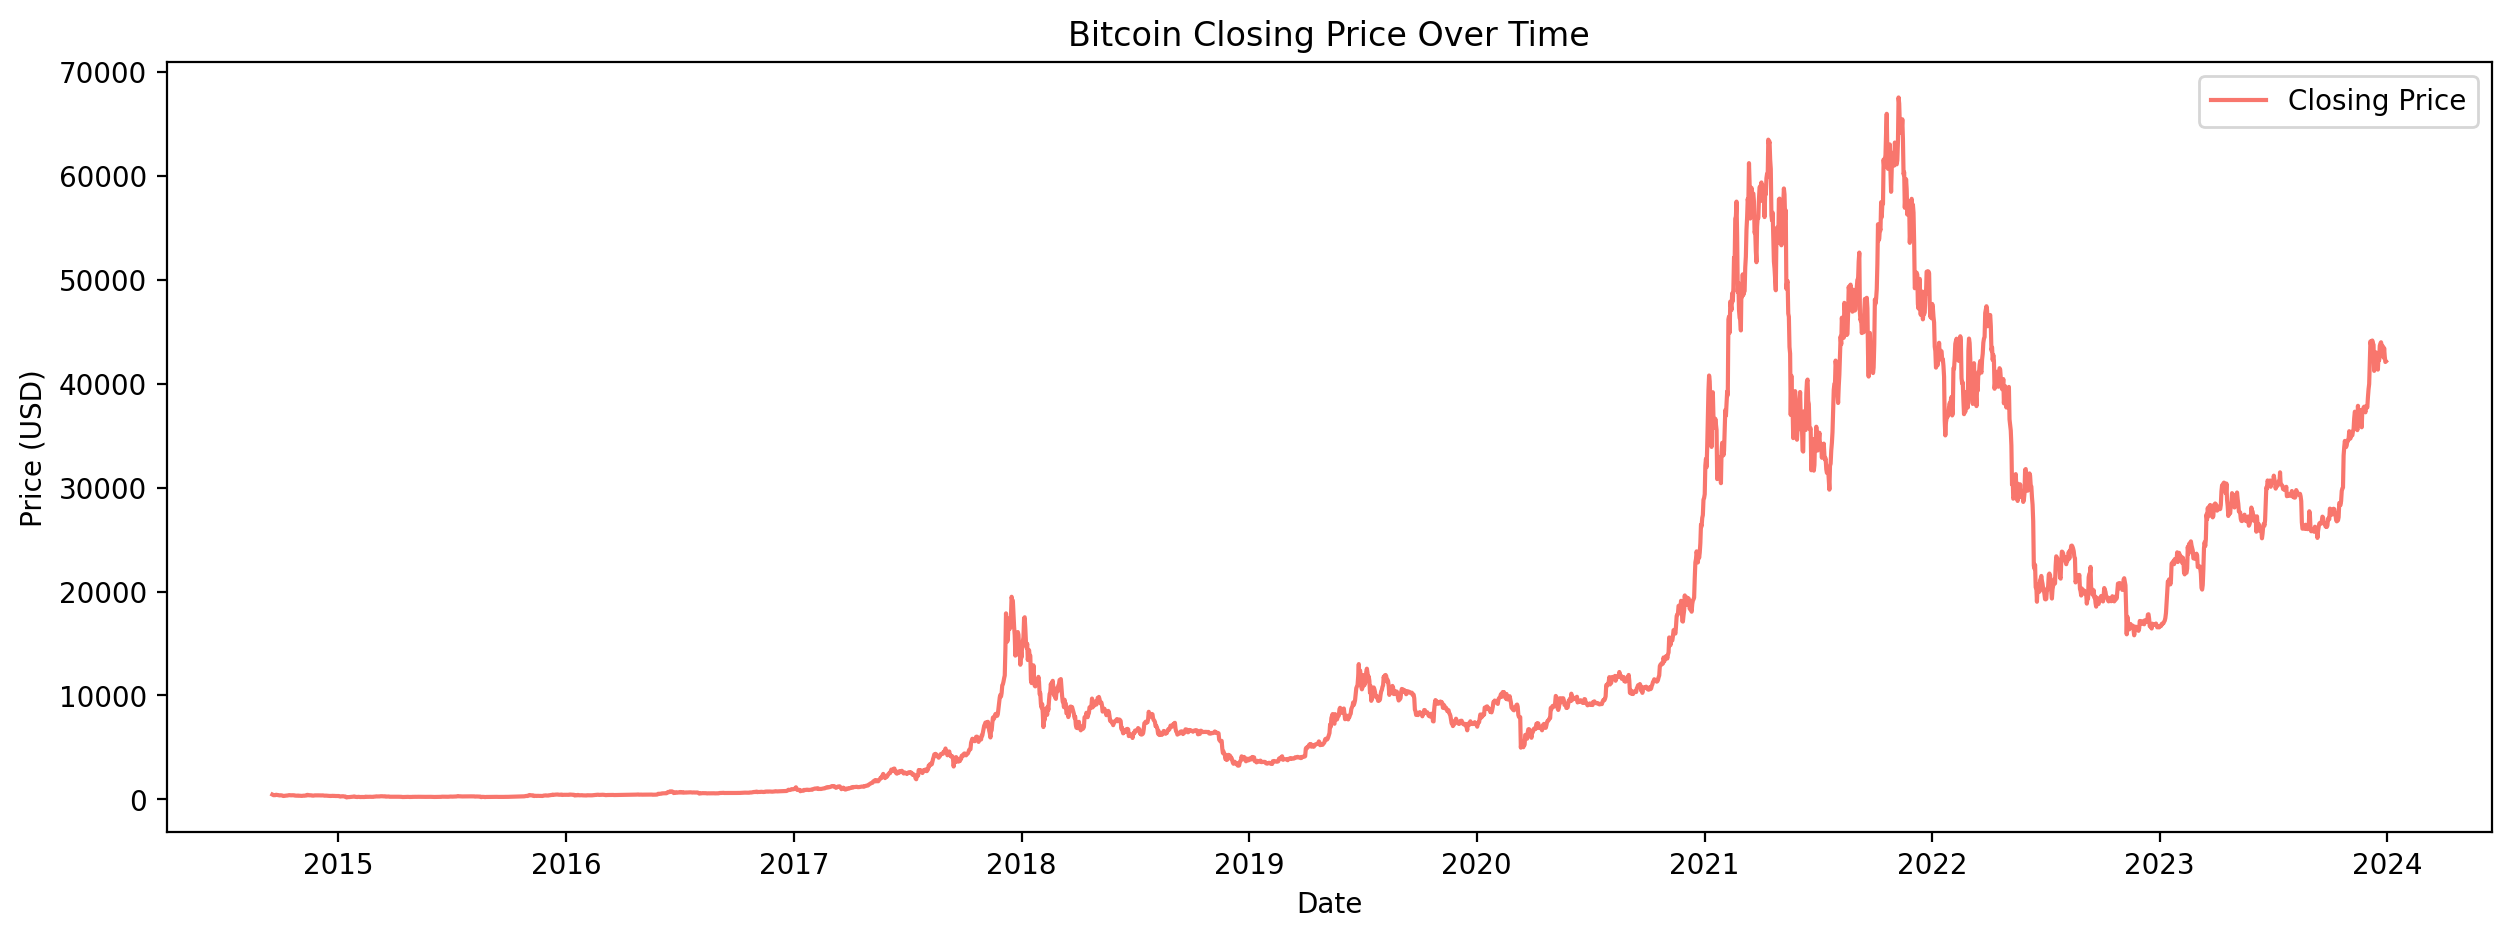

In [11]:
# Bitcoin Closing Price over Time
plt.figure(figsize=(15,5), dpi=200)
sns.lineplot(data=df, x='Date', y='Close', label='Closing Price', color='#F8766D')
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

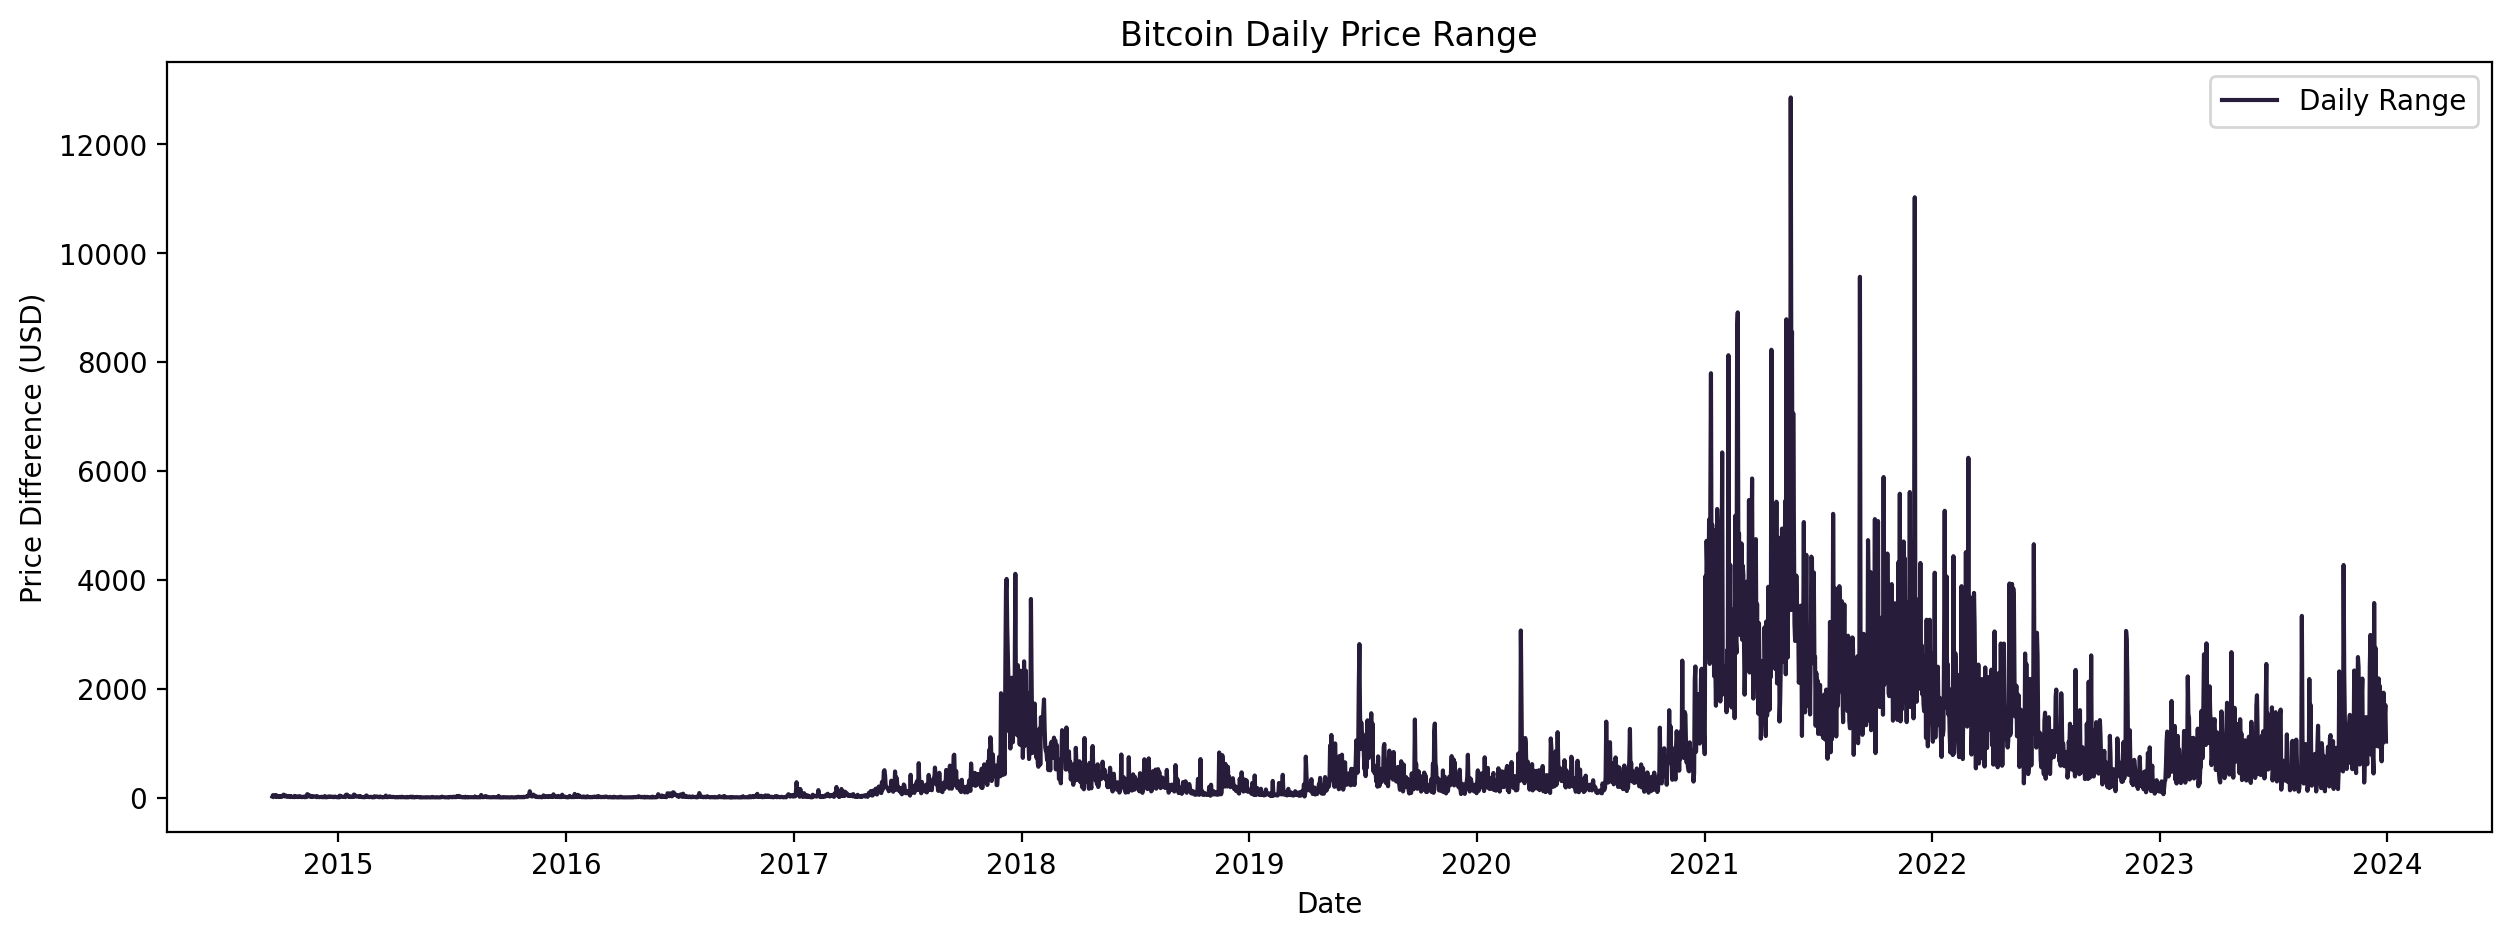

In [12]:
plt.figure(figsize=(15,5), dpi=200)
sns.lineplot(data=df, x='Date', y=df['High'] - df['Low'], label='Daily Range', color='#271d3b')
plt.title('Bitcoin Daily Price Range')
plt.xlabel('Date')
plt.ylabel('Price Difference (USD)')
plt.legend()
plt.show()

# Seasonality

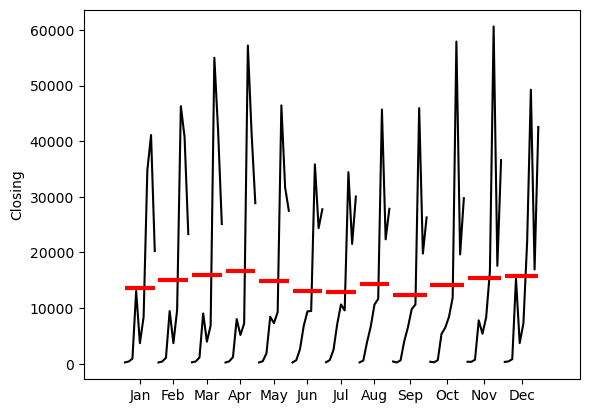

In [15]:
# Plotting the monthly seasonality
month_plot(df['Close'].resample('ME').mean(), ylabel='Closing')
plt.show()

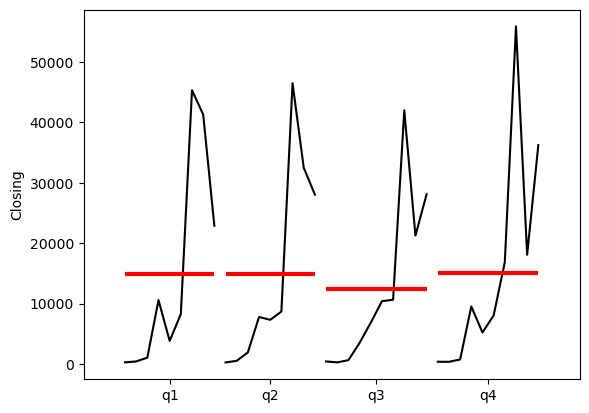

In [16]:
# Plotting the quarterly seasonality
quarter_plot(df['Close'].resample('QE').mean(), ylabel='Closing')
plt.show()

# Seasonal Decompose

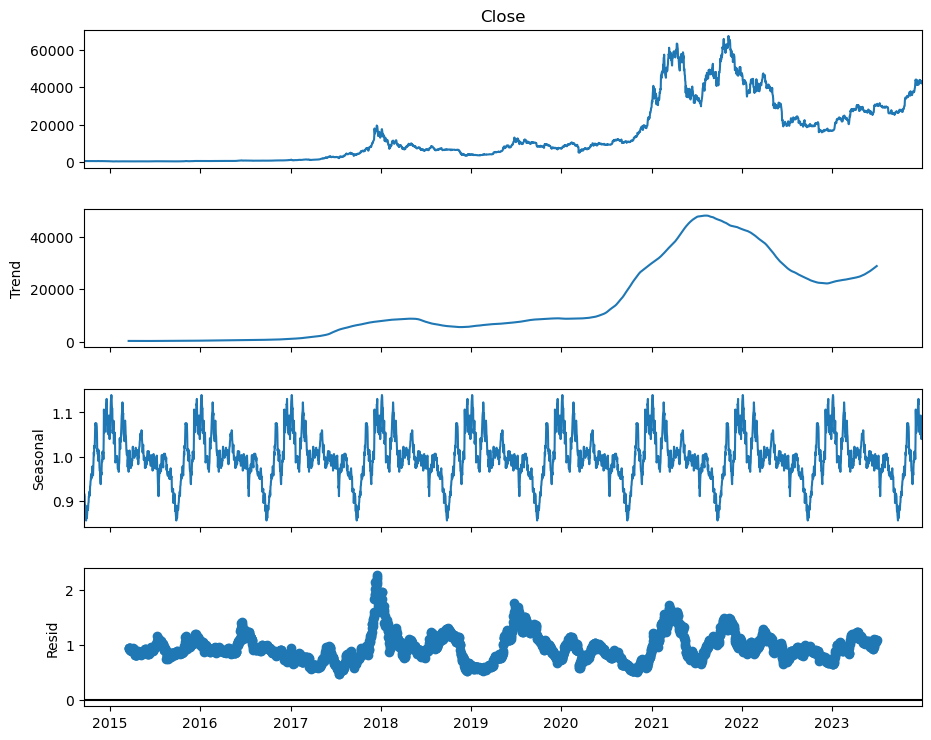

In [19]:
# Seasonal Decomposition plot for Bitcoin data (multiplicative)
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

# Auto-Correlation

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

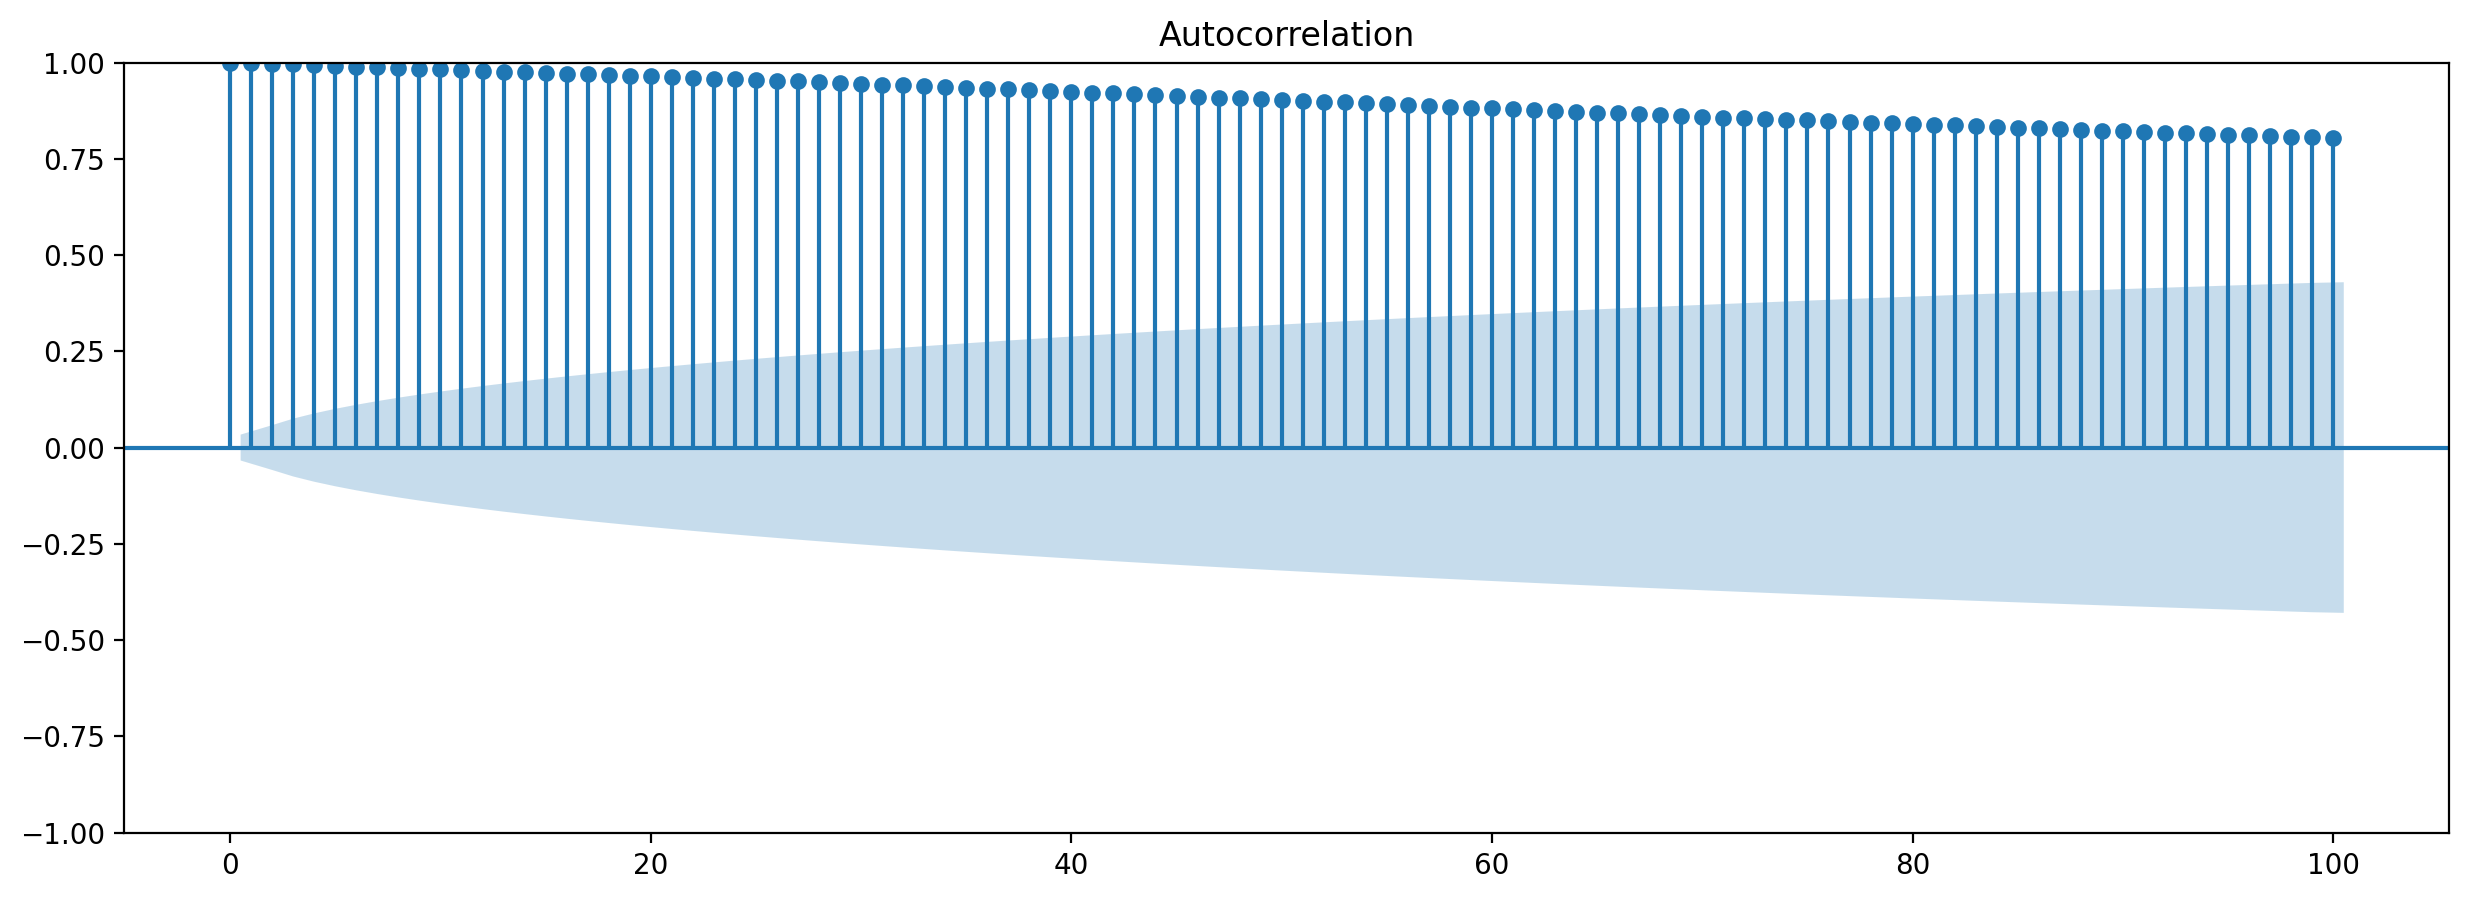

In [22]:
fig, ax = plt.subplots(figsize = (15,5), dpi=200)
plot_acf(df['Close'], lags=100, ax=ax)
plt.show()

# Partial Autocorrelation

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf

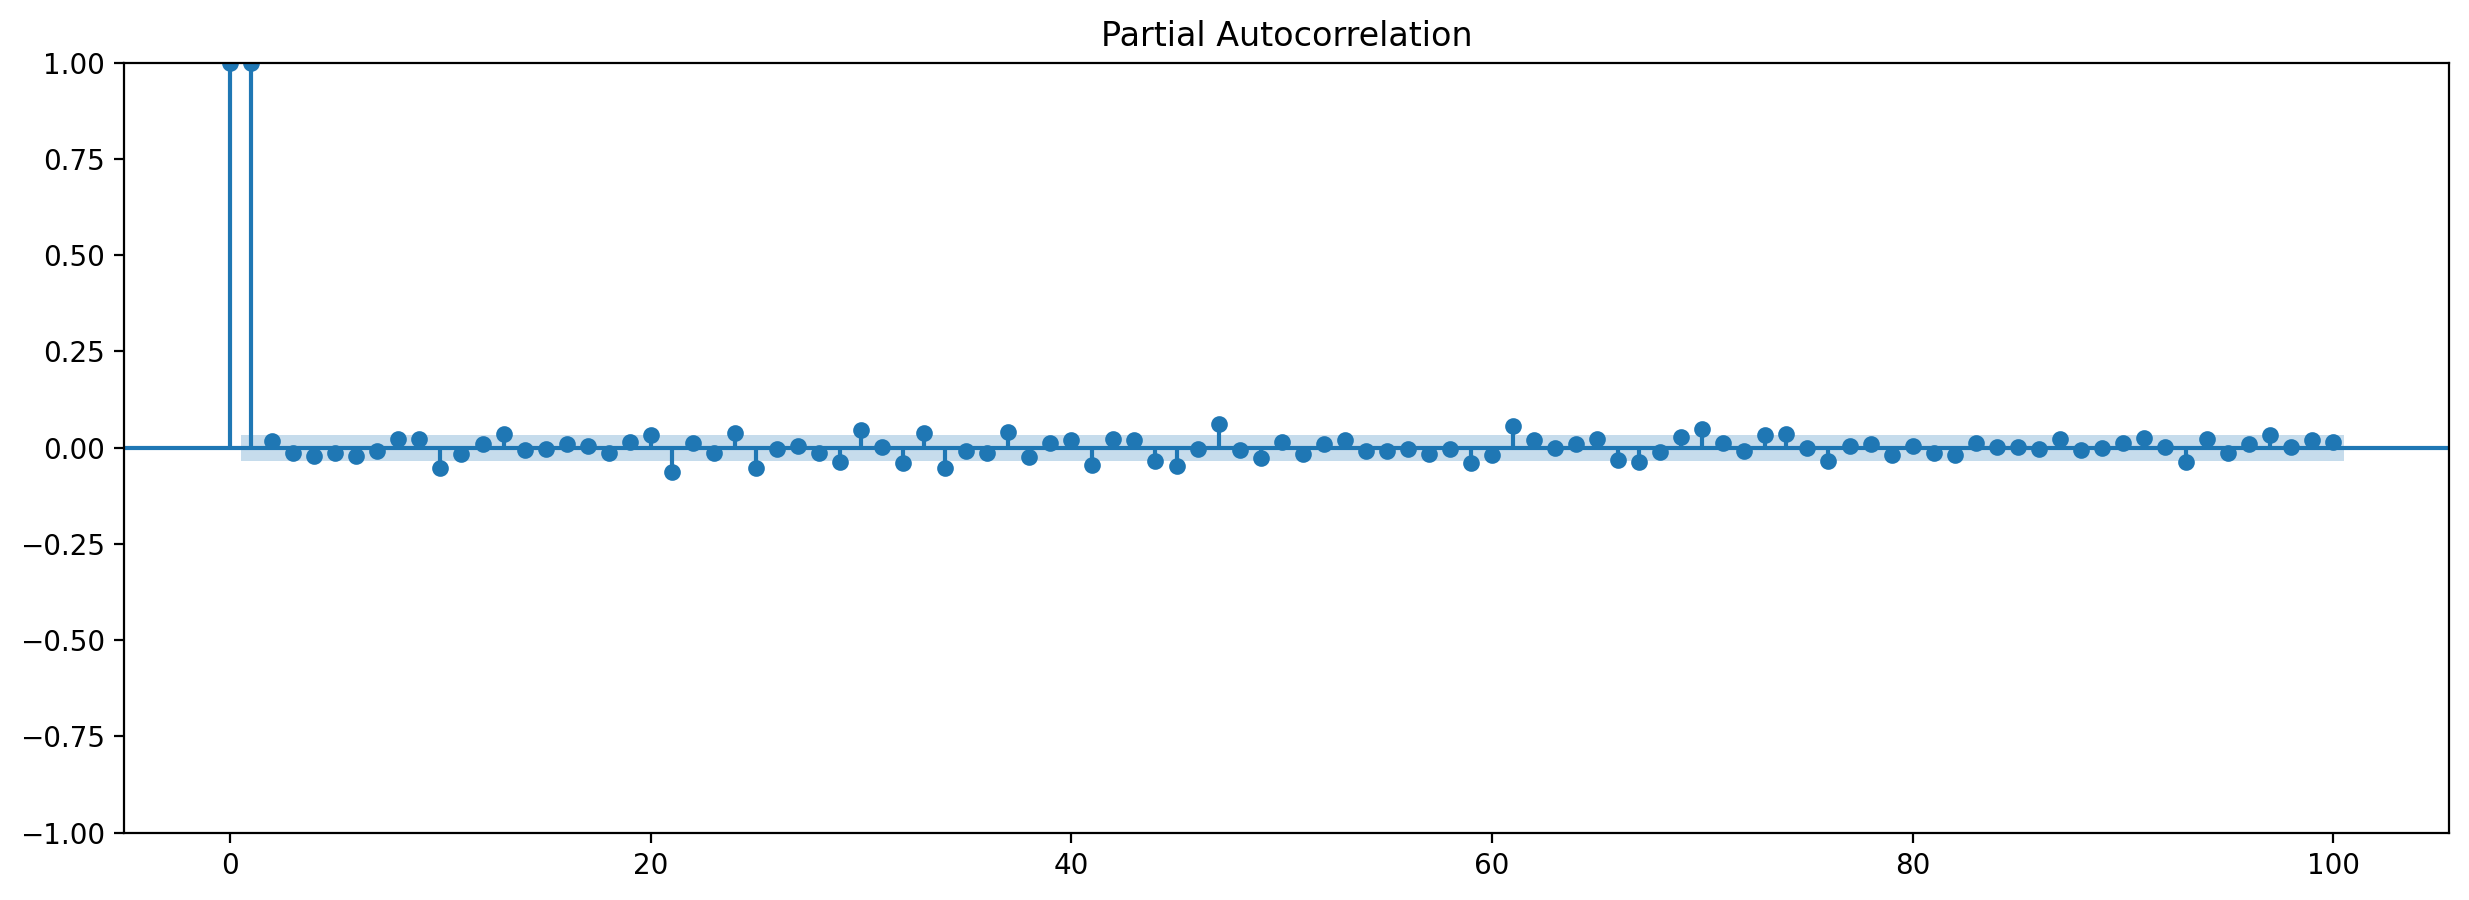

In [25]:
fig, ax = plt.subplots(figsize = (15,5), dpi=200)
plot_pacf(df['Close'], lags=100, ax=ax)
plt.show()

In [12]:
df = df.rename(columns = {'Close':'y'})

In [14]:
# Training and Test Split
periods = 30
train, test = df.iloc[:-periods,3], df.iloc[-periods:,3]

In [32]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
    # Plot training, test and forecasts
    plt.figure(figsize=(15,5),dpi=200)
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label='Predictions')
    plt.title(f"Train, Test and Predictions with {chart_title}")
    plt.legend()
    plt.show()
    mae = mean_absolute_error(test,predictions)
    rmse = root_mean_squared_error(test,predictions)
    mape = mean_absolute_percentage_error(test,predictions)
    print(f"The MAE is {mae:.2f}")
    print(f"The RMSE is {rmse:.2f}")
    print(f"The MAPE is {100*mape:.2f}%")

# Simple Exponential Smoothing

In [30]:
model_simple = SimpleExpSmoothing(train).fit()
predictions_simple = model_simple.forecast(len(test))

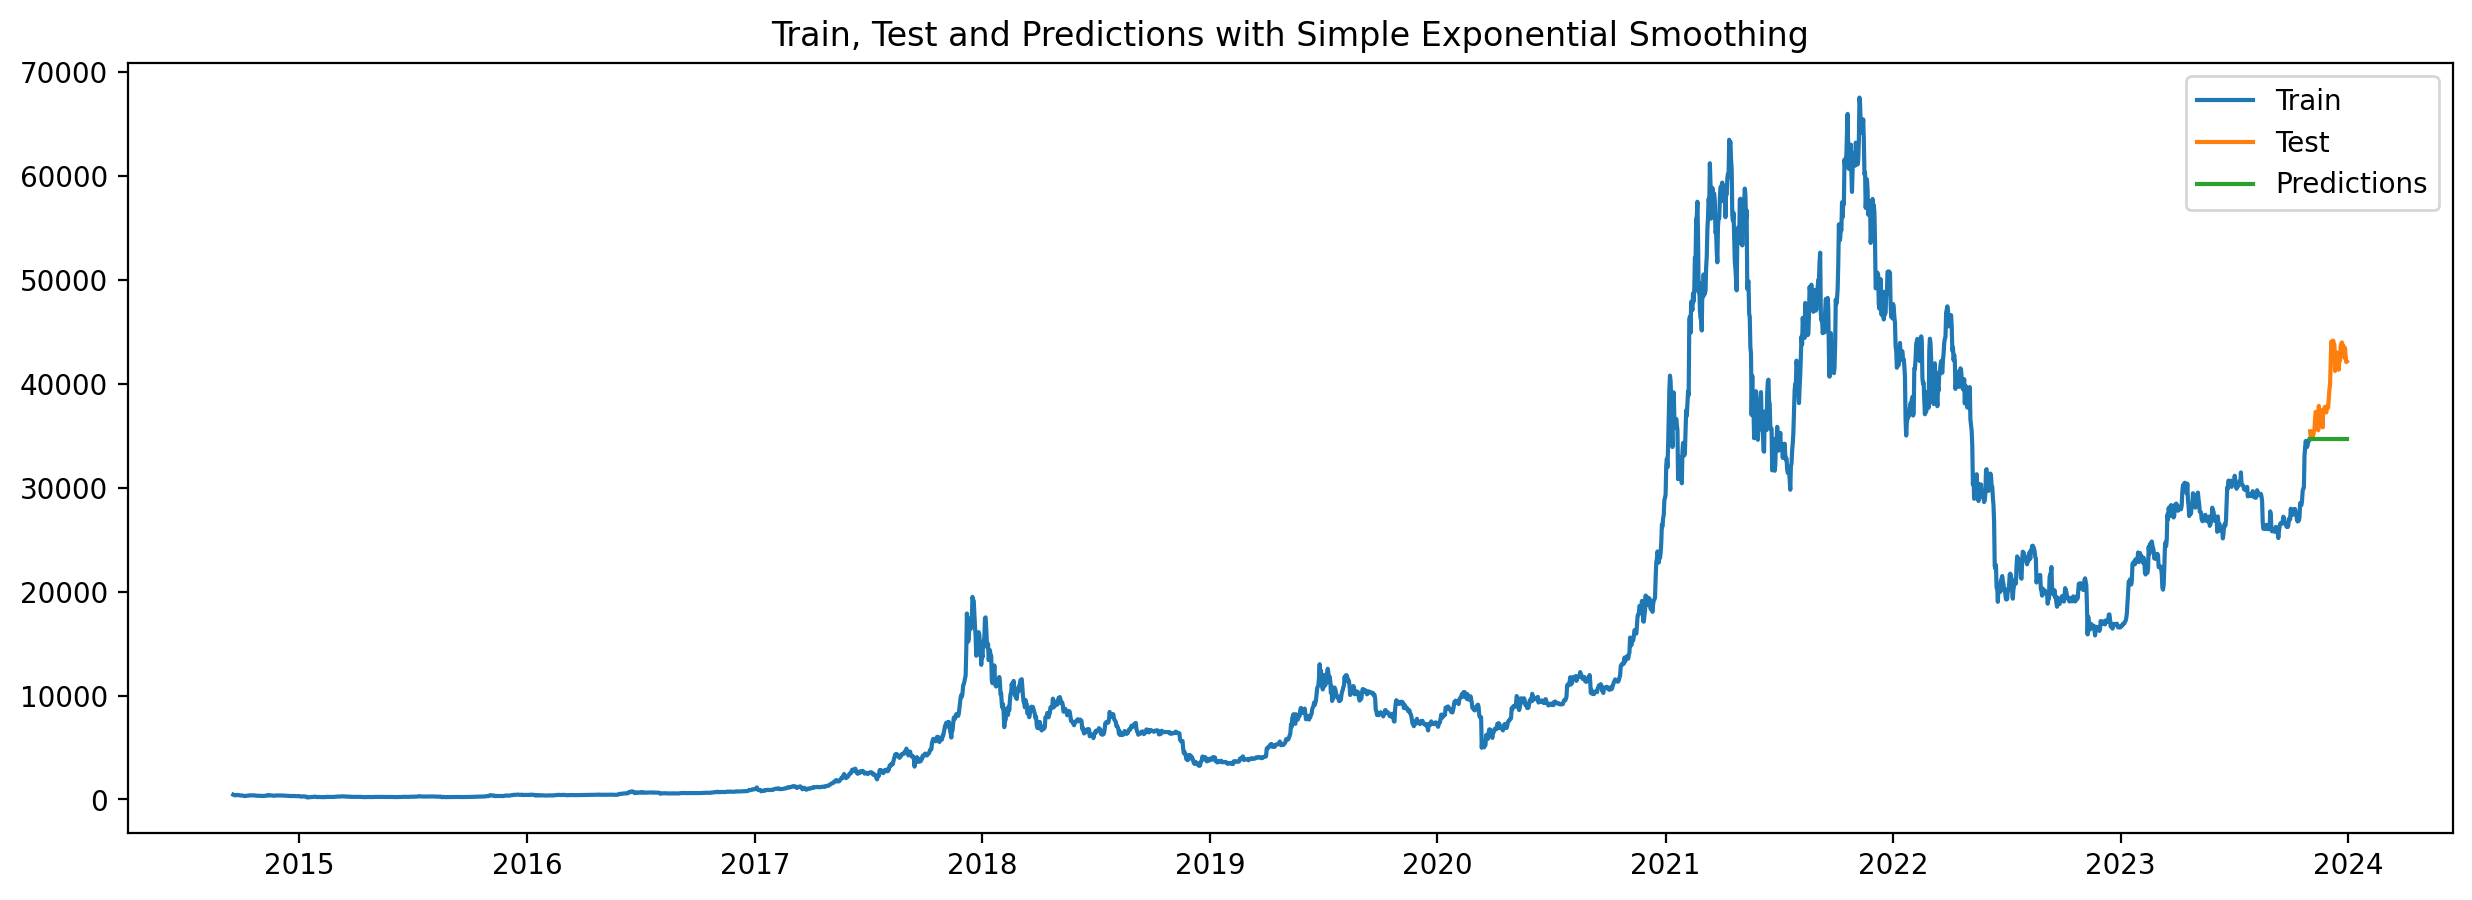

The MAE is 4911.17
The RMSE is 5870.43
The MAPE is 11.83%


In [31]:
model_assessment(train,test,predictions_simple,"Simple Exponential Smoothing")

# Double Exponential Smoothing

In [ ]:
model_double = ExponentialSmoothing(train, trend='add', seasonal=None).fit()  # trend = 'add'
predictions_double = model_double.forecast(len(test)) 

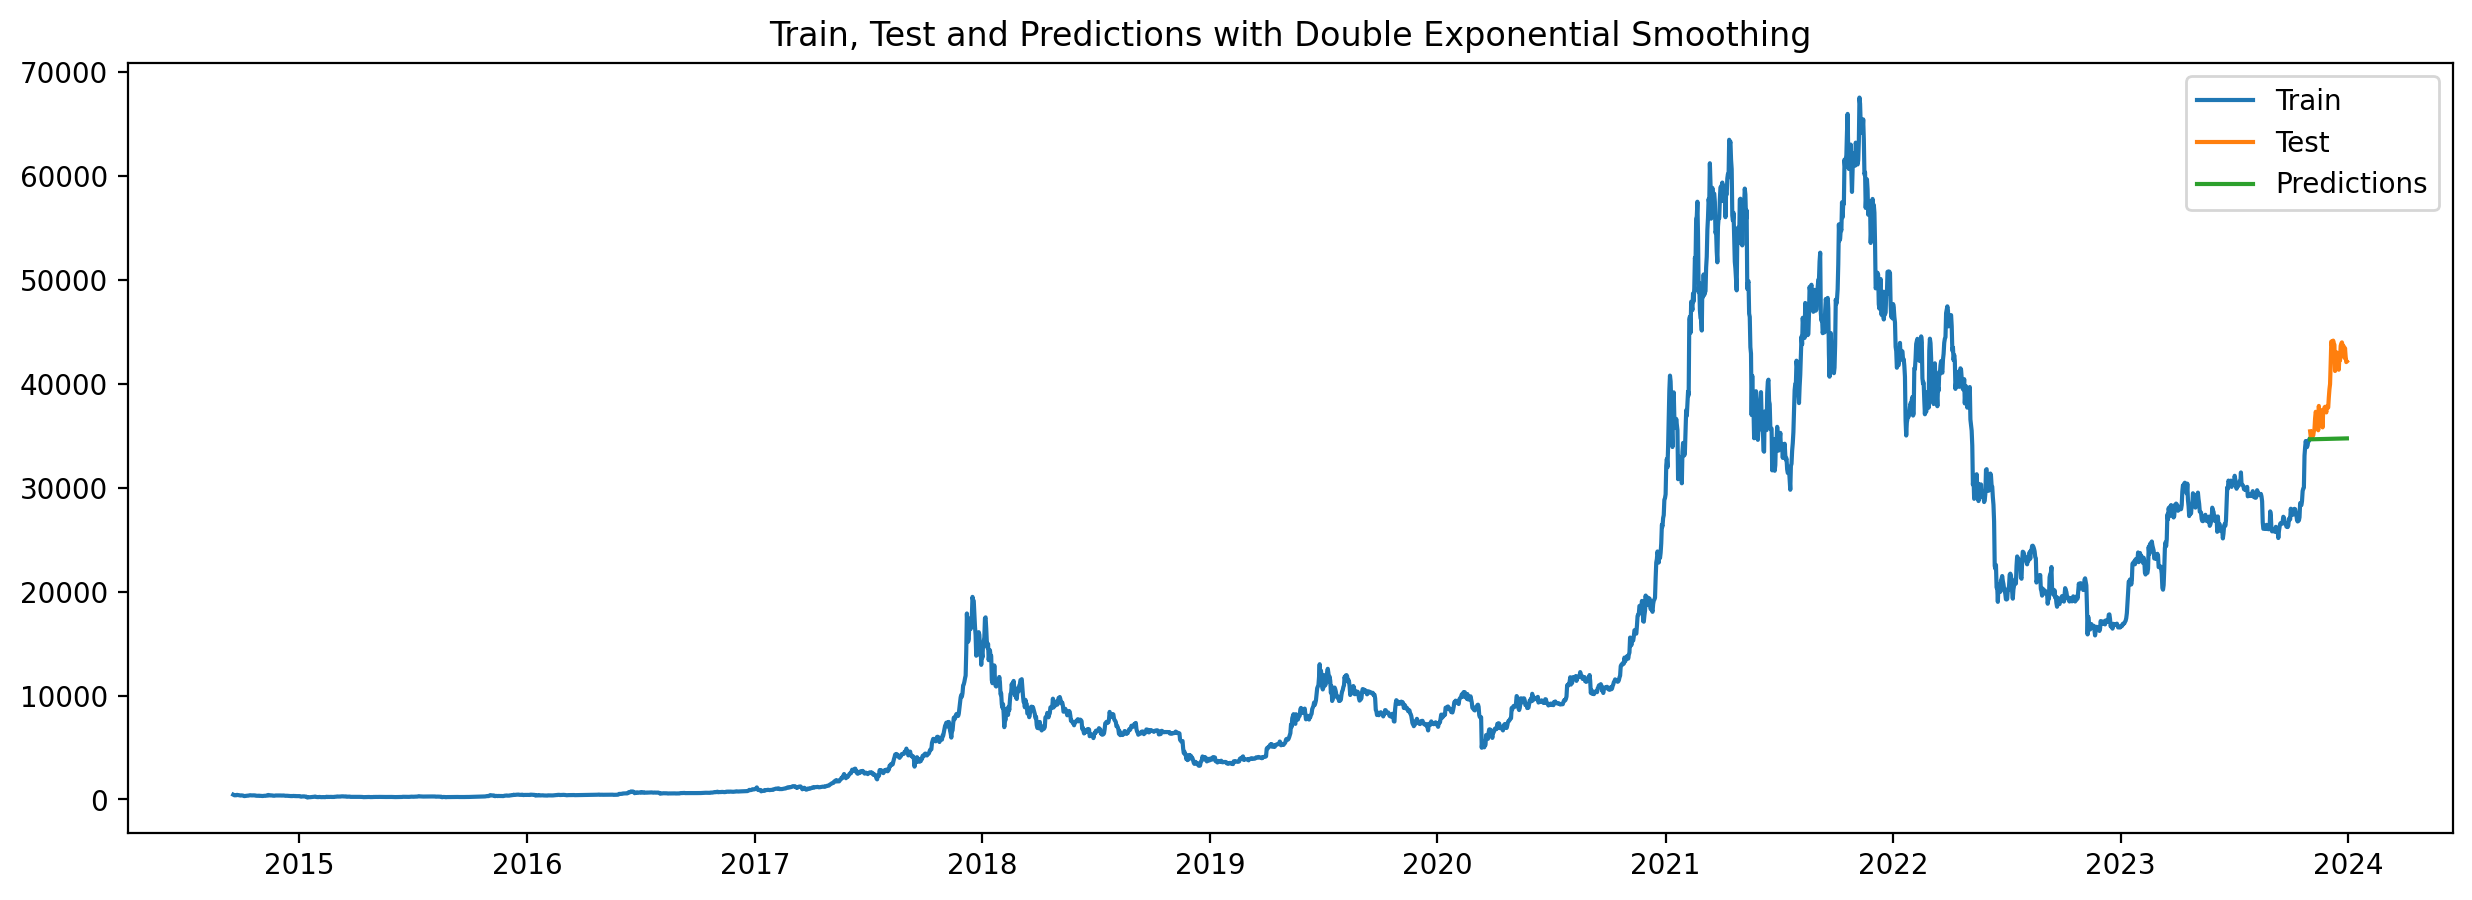

The MAE is 4866.58
The RMSE is 5820.04
The MAPE is 11.72%


In [34]:
model_assessment(train,test,predictions_double,"Double Exponential Smoothing")

In [ ]:
model_double = ExponentialSmoothing(train, trend='mul', seasonal=None).fit()  # trend = 'mul'
predictions_double = model_double.forecast(len(test)) 

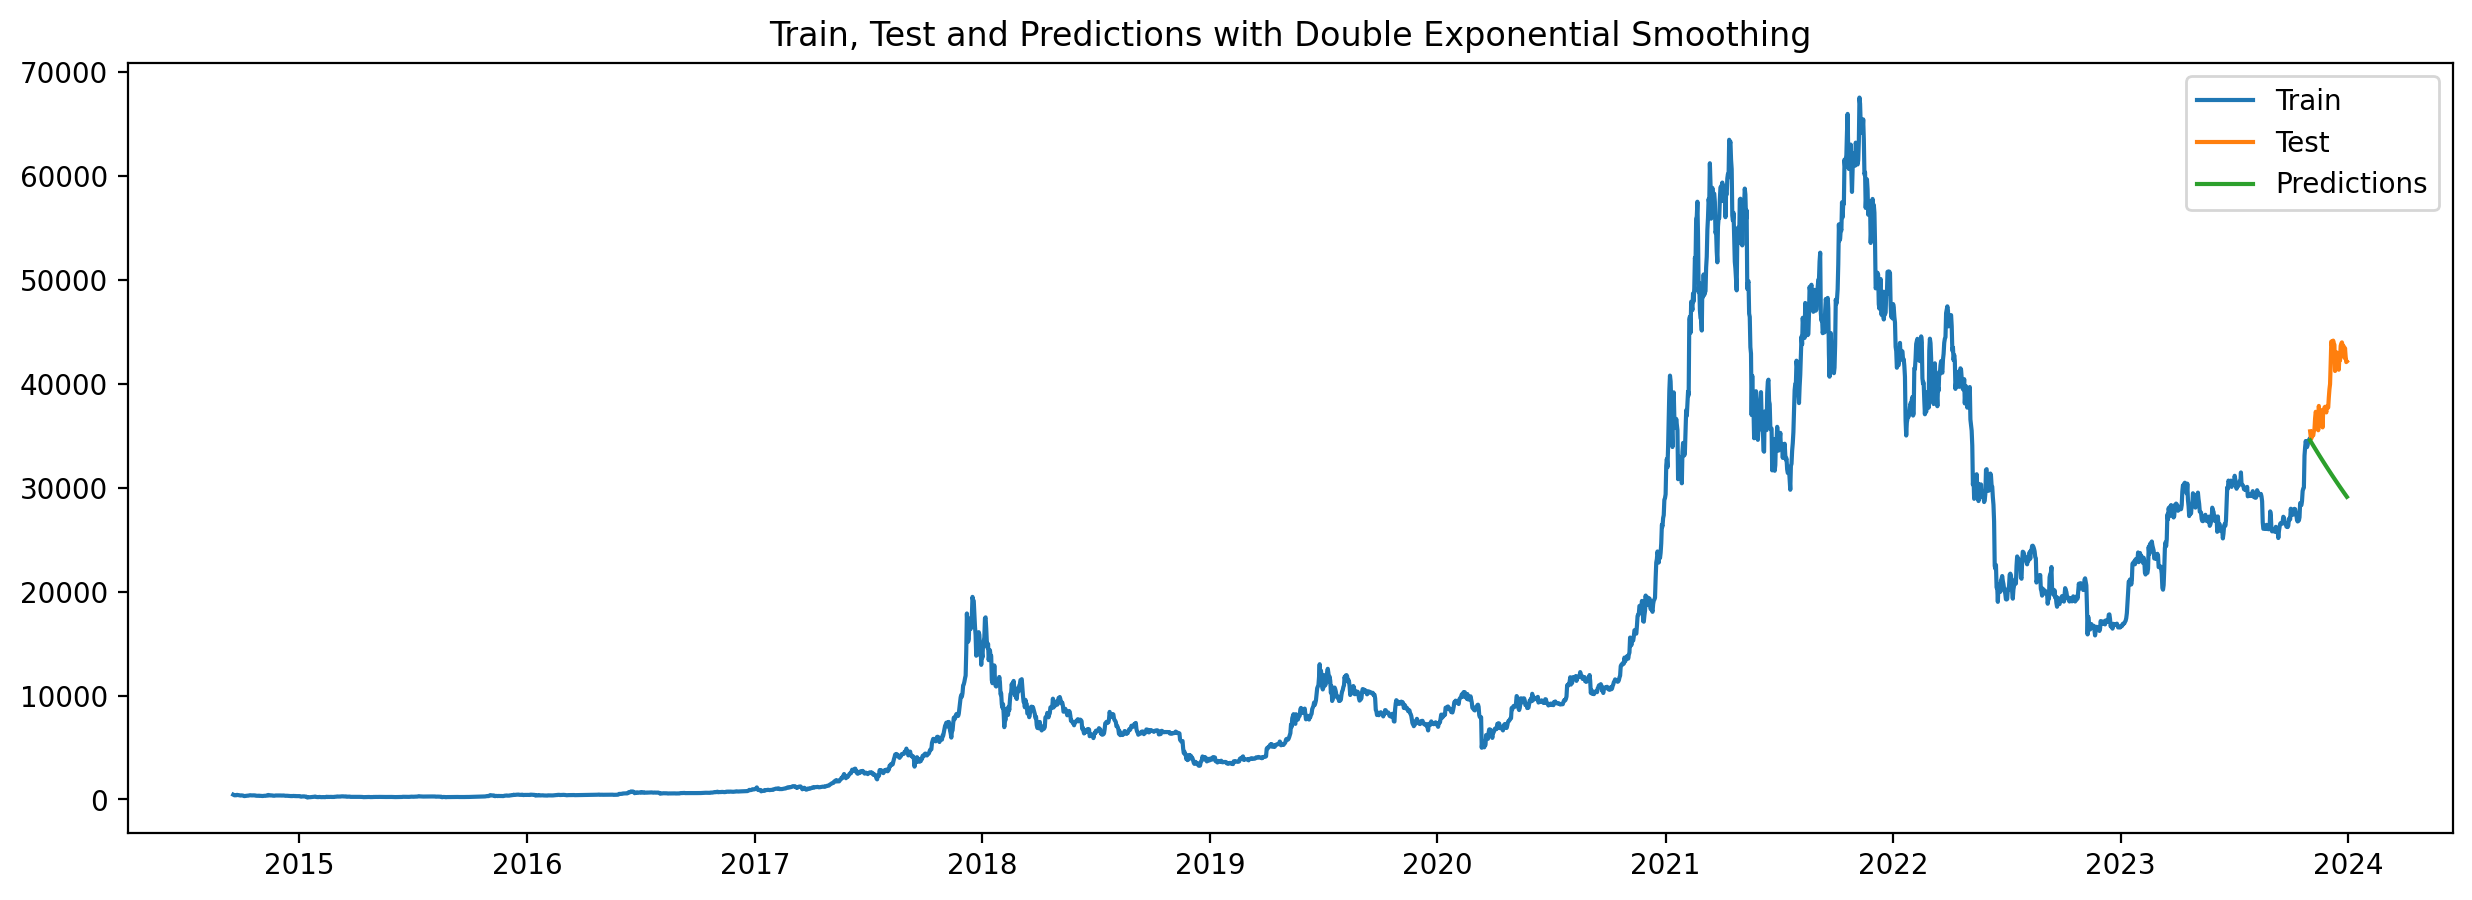

The MAE is 7805.70
The RMSE is 9117.77
The MAPE is 18.89%


In [36]:
model_assessment(train,test,predictions_double,"Double Exponential Smoothing")

# Triple Exponential Smoothing

In [ ]:
model_triple = ExponentialSmoothing(train, trend='add', seasonal= 'mul', seasonal_periods=7).fit()  # trend = 'mul'
predictions_triple = model_triple.forecast(len(test)) 

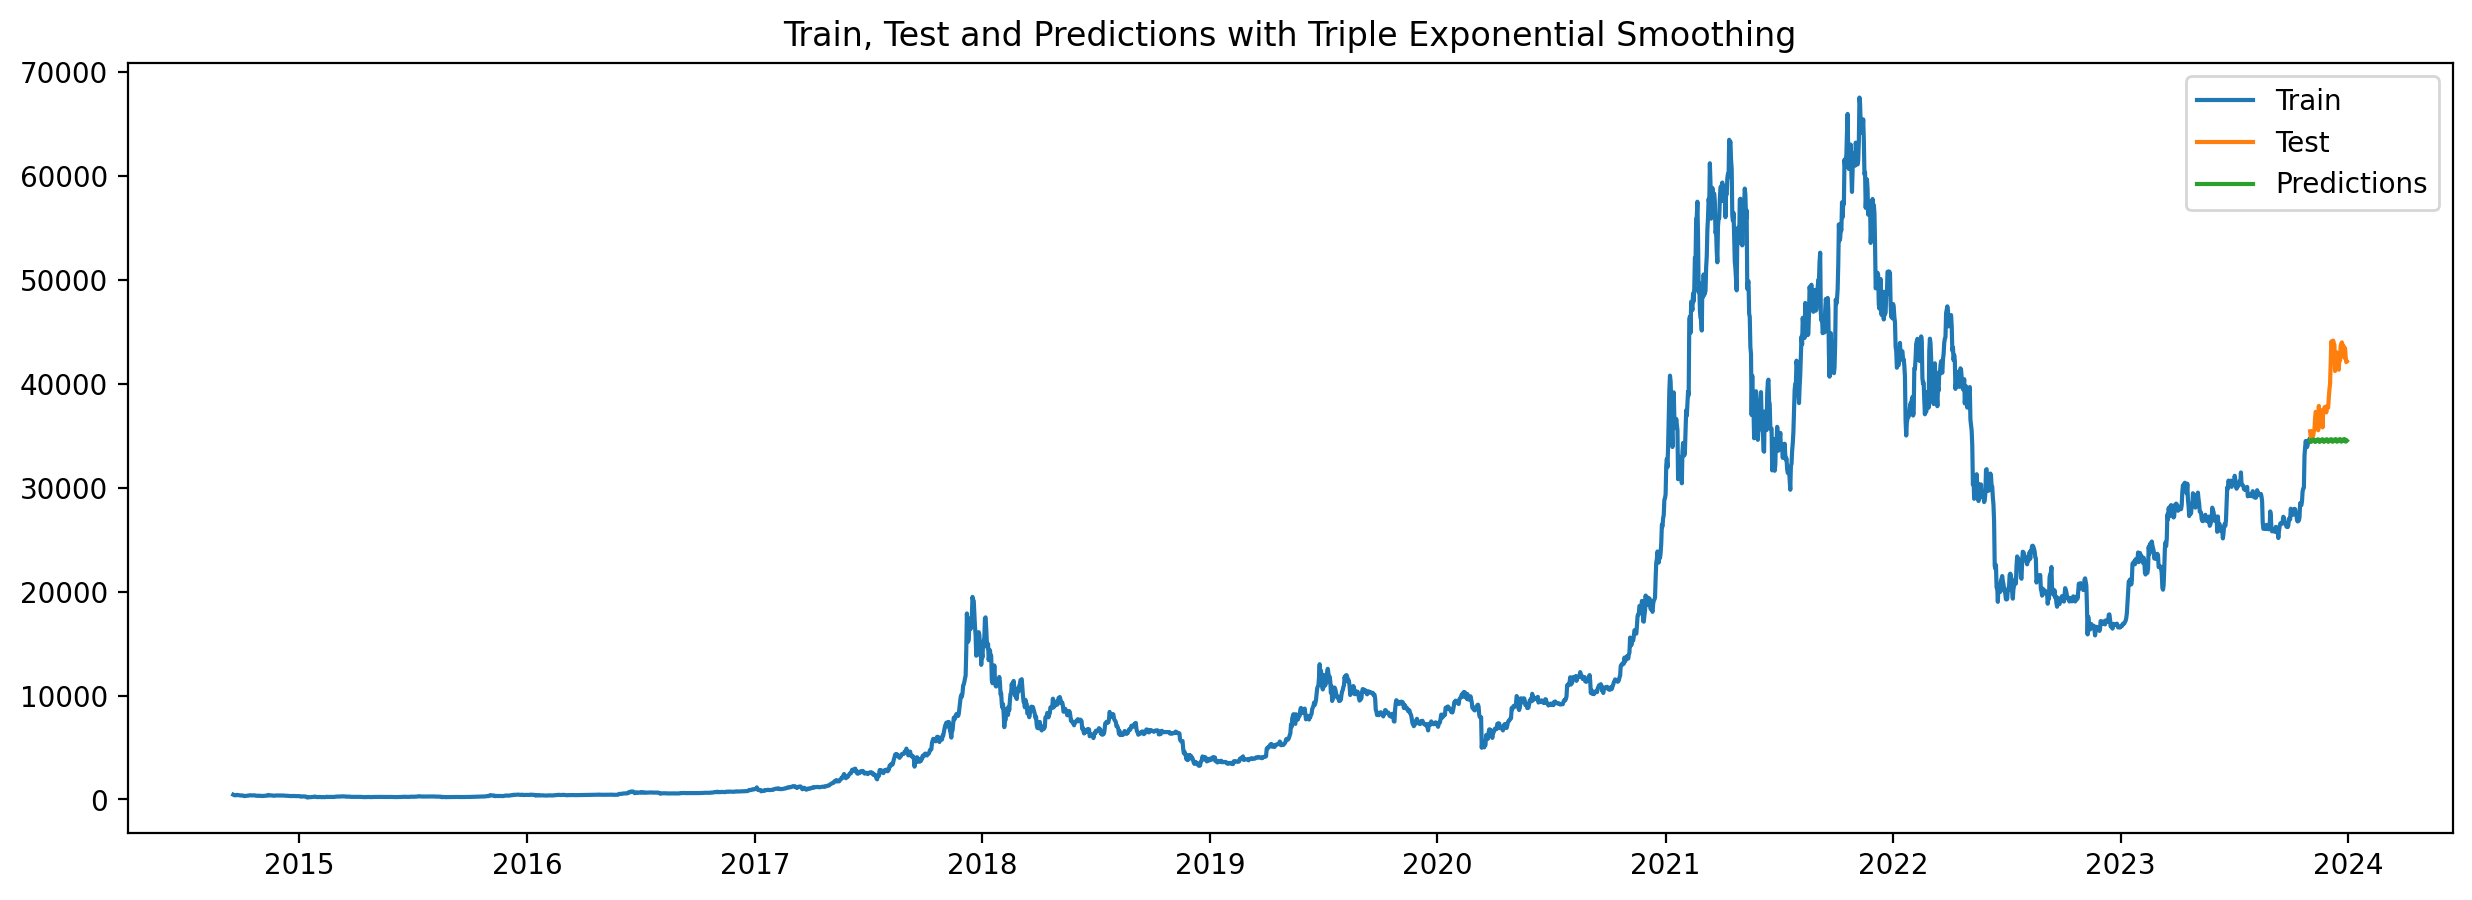

The MAE is 5024.15
The RMSE is 5962.17
The MAPE is 12.12%


In [39]:
model_assessment(train,test,predictions_triple,"Triple Exponential Smoothing")

In [ ]:
model_triple = ExponentialSmoothing(train, trend='mul', seasonal= 'mul', seasonal_periods=7).fit()  # trend = 'mul'
predictions_triple = model_triple.forecast(len(test)) 

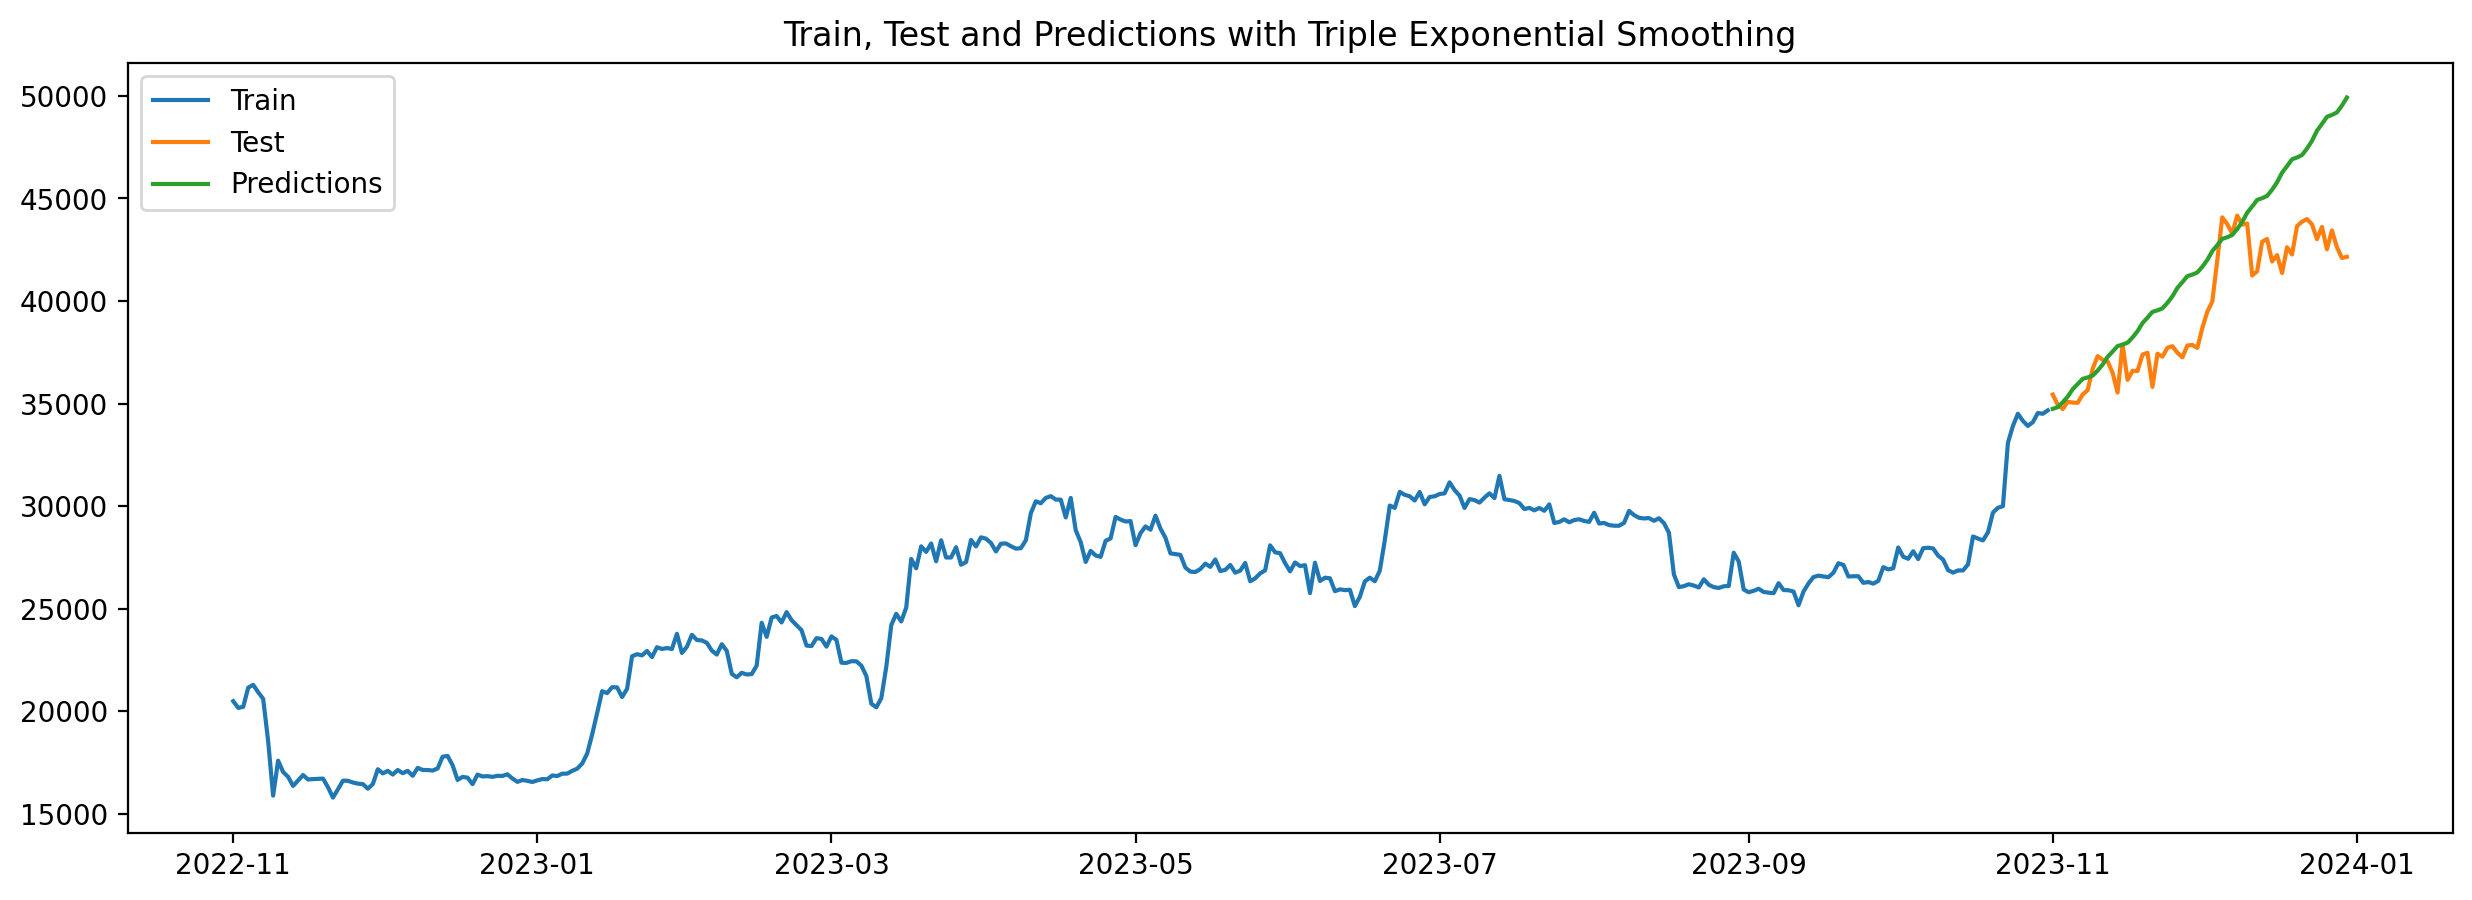

The MAE is 2491.96
The RMSE is 3154.54
The MAPE is 6.16%


In [41]:
model_assessment(train['2022-11':],test,predictions_triple,"Triple Exponential Smoothing")

In [ ]:
model_triple = ExponentialSmoothing(train, trend='mul', seasonal= 'add', seasonal_periods=7).fit()  # trend = 'mul'
predictions_triple = model_triple.forecast(len(test)) 

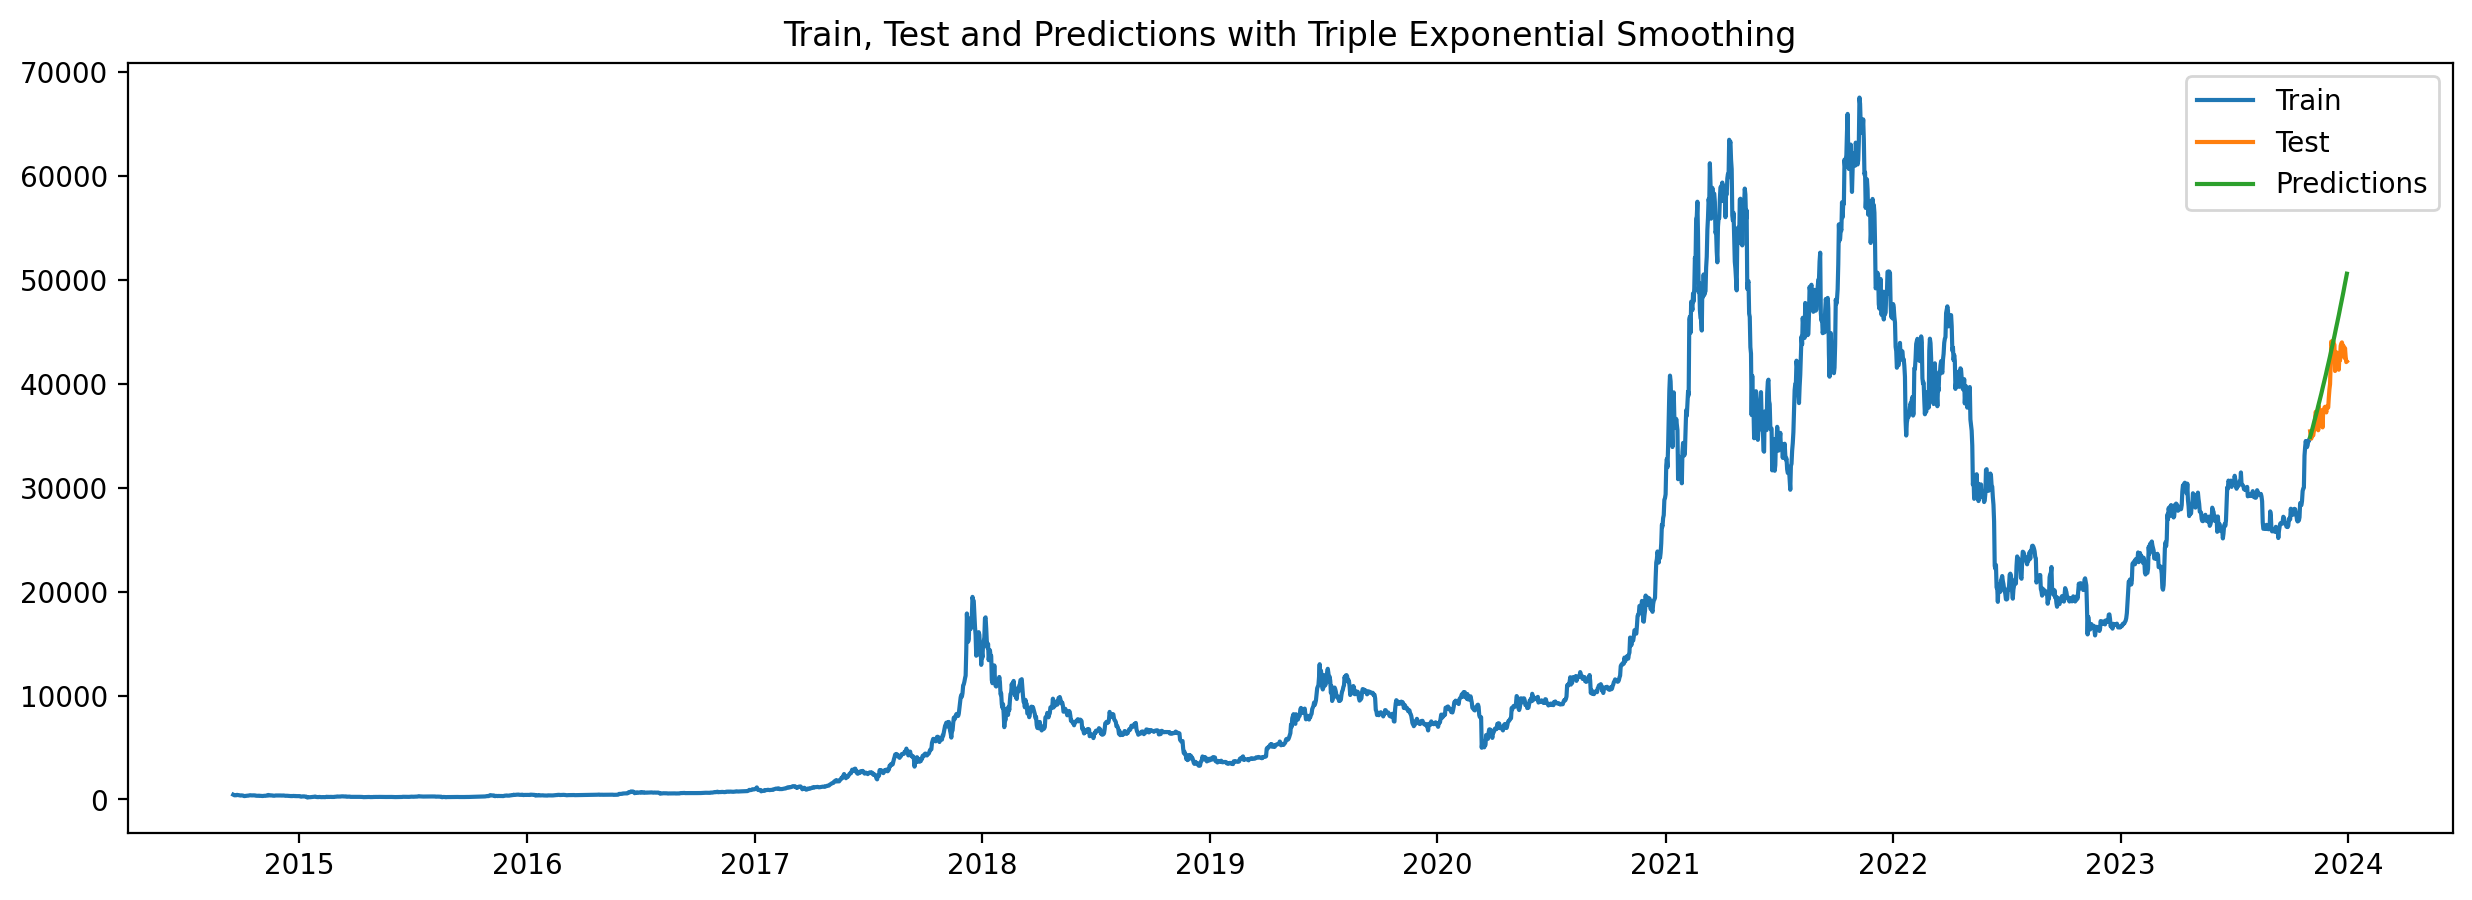

The MAE is 2764.18
The RMSE is 3487.31
The MAPE is 6.83%


In [43]:
model_assessment(train,test,predictions_triple,"Triple Exponential Smoothing")

# Stationarity

Original Series - ADF Statistic: -1.3123
Original Series - p-value: 0.6235
The series is non-stationary (fail to reject the null hypothesis).
--------------------------------------------------
Differenced Series - ADF Statistic: -9.7353
Differenced Series - p-value: 0.0000
The series is stationary (reject the null hypothesis).
--------------------------------------------------


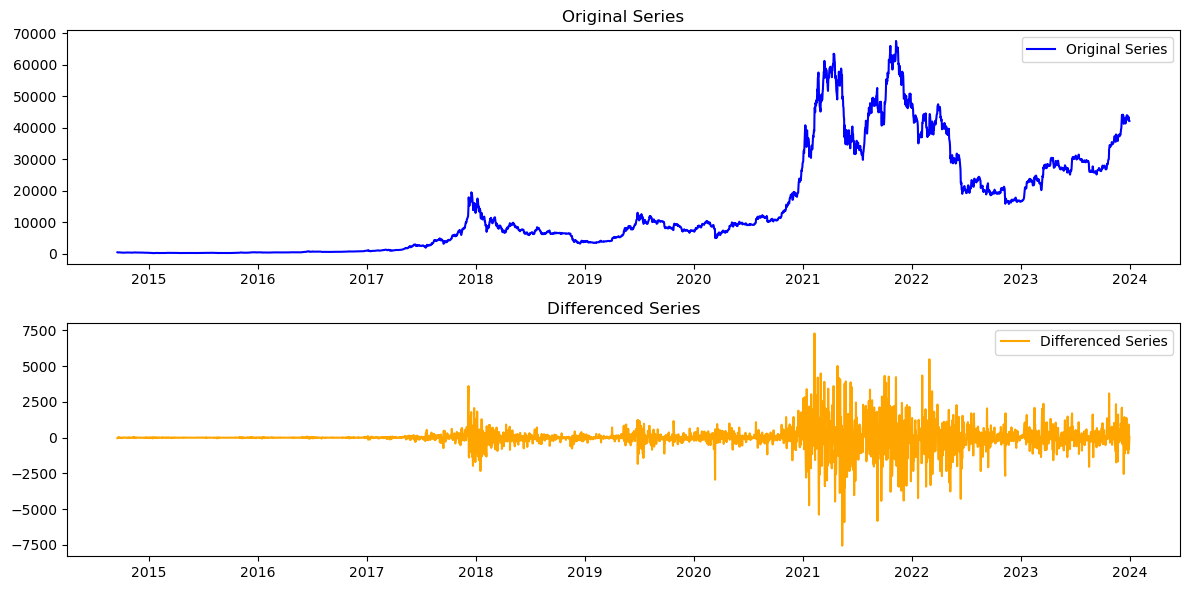

In [91]:
# Check for stationarity using ADF test
def check_stationarity(series, title="Time Series"):
    result = adfuller(series)
    print(f"{title} - ADF Statistic: {result[0]:.4f}")
    print(f"{title} - p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("The series is stationary (reject the null hypothesis).")
    else:
        print("The series is non-stationary (fail to reject the null hypothesis).")
    print("-" * 50)

# Original series
check_stationarity(df['y'], title="Original Series")

# Differencing the series
df['y_diff'] = df['y'].diff()

# Drop the first NaN row caused by differencing
df_diff = df.dropna()

# Check stationarity on the differenced series
check_stationarity(df_diff['y_diff'], title="Differenced Series")

# Plot the original and differenced series
plt.figure(figsize=(12, 6))

# Original series plot
plt.subplot(2, 1, 1)
plt.plot(df['y'], label='Original Series', color='blue')
plt.title("Original Series")
plt.legend()

# Differenced series plot
plt.subplot(2, 1, 2)
plt.plot(df_diff['y_diff'], label='Differenced Series', color='orange')
plt.title("Differenced Series")
plt.legend()

plt.tight_layout()
plt.show()

# ARIMA Model

In [64]:
# Training & Test Split
test_days = 30
train,test = df.iloc[:-test_days], df.iloc[-test_days:]


In [102]:
model_arima = auto_arima(train['y'], seasonal=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3362
Model:               SARIMAX(3, 1, 2)   Log Likelihood              -27134.462
Date:                Fri, 20 Dec 2024   AIC                          54280.924
Time:                        16:35:56   BIC                          54317.644
Sample:                    09-17-2014   HQIC                         54294.056
                         - 11-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8165      0.012     67.615      0.000       0.793       0.840
ar.L2         -0.9507      0.010    -95.724      0.000      -0.970      -0.931
ar.L3         -0.0038      0.010     -0.391      0.696      -0.023       0.015
ma.L1         -0.8464      0.008   -100.571      0.000      -0.863      -0.830
ma.L2          0.9629      0.008    115.059      0.000       0.946       0.979
sigma2      6.069e+05   5017.981    120.950      0.000    5.97e+05    6.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             38150.50
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             435.65   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
# Predictions
predictions_arima = model_arima.predict(n_periods=len(test))
predictions_arima

2023-12-01    37706.173686
2023-12-02    37675.977671
2023-12-03    37658.119801
2023-12-04    37672.269576
2023-12-05    37700.914653
2023-12-06    37710.920211
2023-12-07    37691.804493
2023-12-08    37666.575384
2023-12-09    37664.109792
2023-12-10    37686.153500
2023-12-11    37706.592460
2023-12-12    37702.334622
2023-12-13    37679.343763
2023-12-14    37664.541327
2023-12-15    37674.327470
2023-12-16    37696.477495
2023-12-17    37705.316421
2023-12-18    37691.439285
2023-12-19    37671.621337
2023-12-20    37668.598401
2023-12-21    37685.022952
2023-12-22    37701.383032
2023-12-23    37699.138724
2023-12-24    37681.690930
2023-12-25    37669.515843
2023-12-26    37676.170056
2023-12-27    37693.244019
2023-12-28    37700.905645
2023-12-29    37690.904725
2023-12-30    37675.390288
Freq: D, dtype: float64

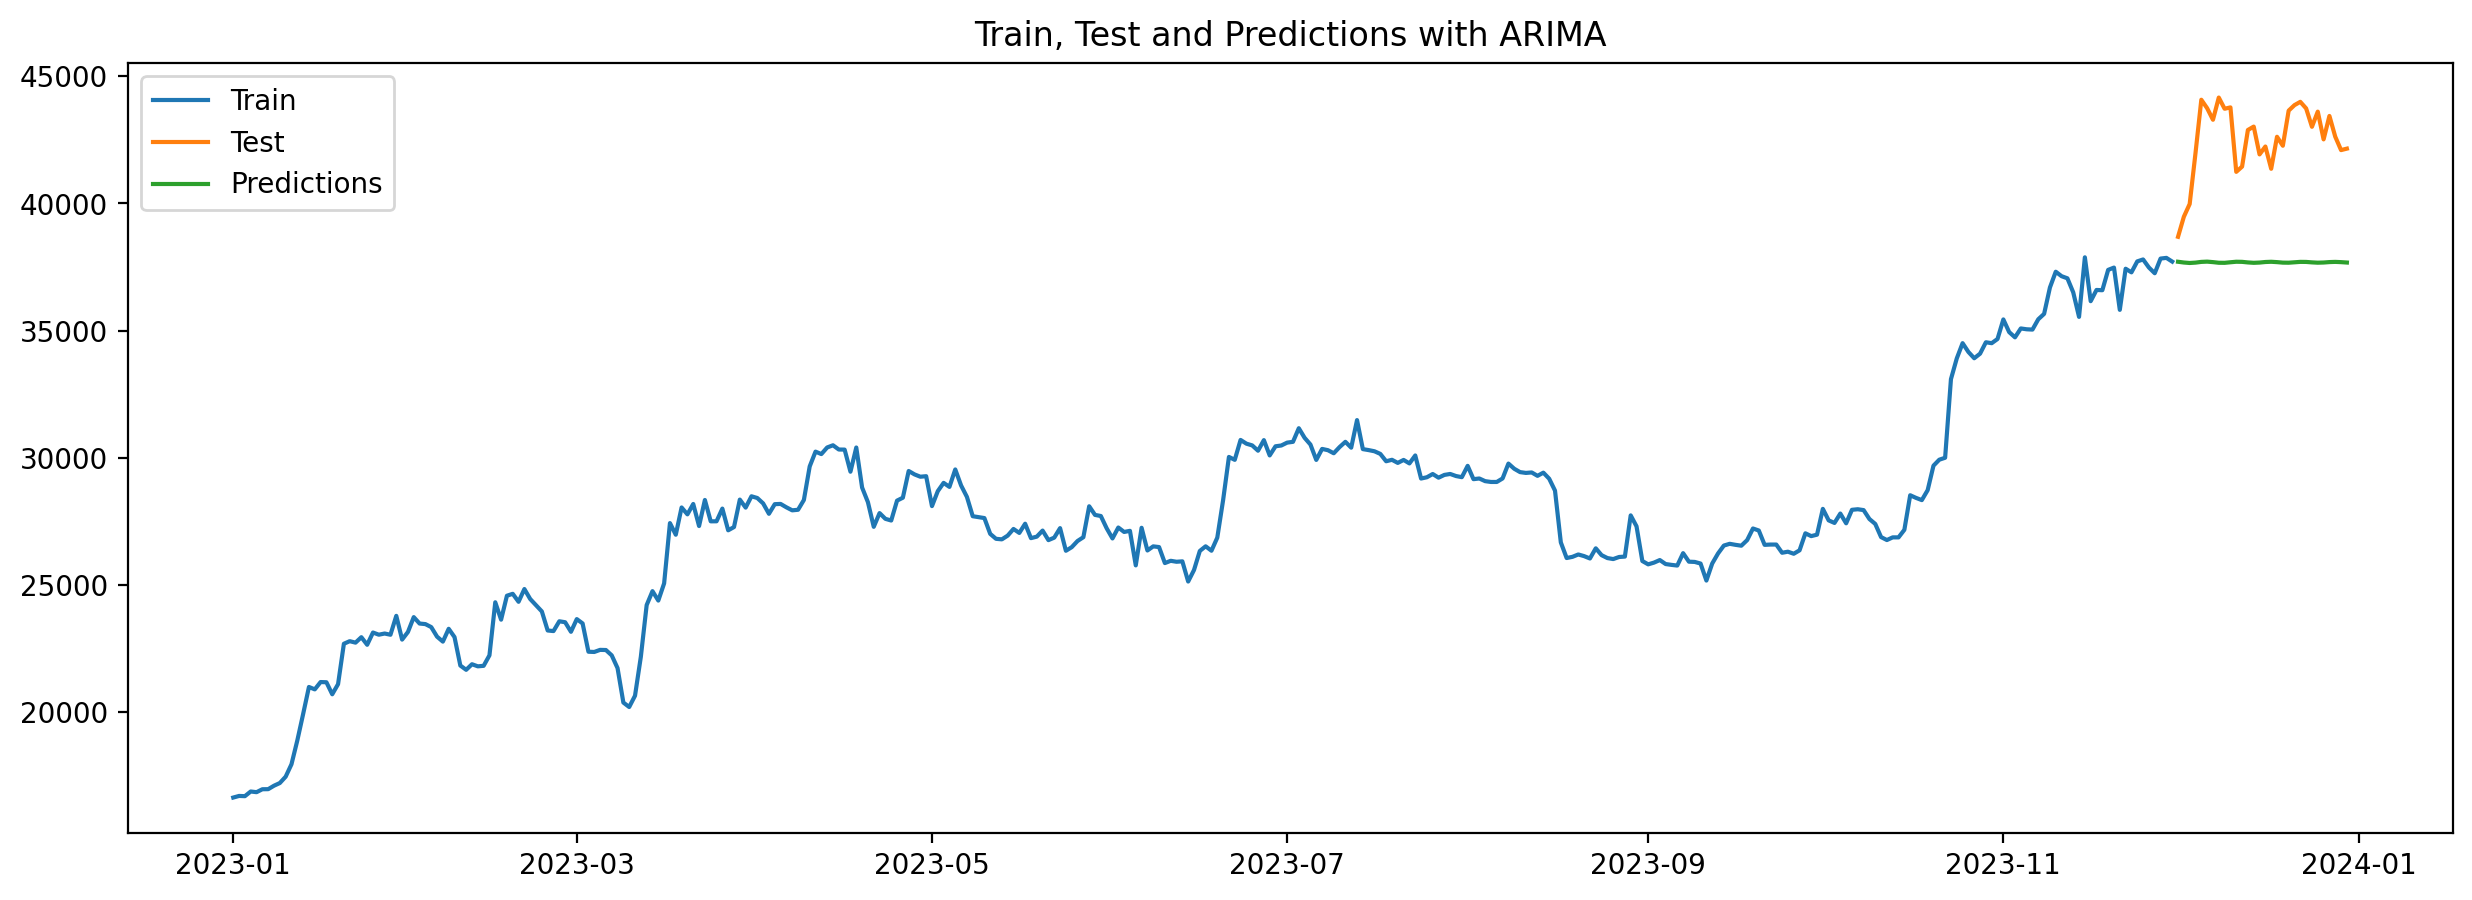

The MAE is 4870.72
The RMSE is 5056.73
The MAPE is 11.35%


In [117]:
model_assessment(train['y']['2023-01':], test['y'], predictions_arima, "ARIMA")

# SARIMA

In [109]:
model_sarima = auto_arima(train['y'], m=7) 
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 3362
Model:             SARIMAX(2, 1, 1)x(0, 0, 1, 7)   Log Likelihood              -27139.014
Date:                           Fri, 20 Dec 2024   AIC                          54288.029
Time:                                   17:12:53   BIC                          54318.629
Sample:                               09-17-2014   HQIC                         54298.972
                                    - 11-30-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9107      0.022     41.111      0.000       0.867       0.954
ar.L2          0.0435      0.009      4.851      0.000       0.026       0.061
ma.L1         -0.9403      0.020    -47.178      0.000      -0.979      -0.901
ma.S.L7       -0.0592      0.008     -7.496      0.000      -0.075      -0.044
sigma2       6.07e+05   4902.651    123.811      0.000    5.97e+05    6.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             38814.45
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             440.32   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [111]:
# Predictions
predictions_srima = model_sarima.predict(n_periods=len(test))
predictions_srima

2023-12-01    37726.103796
2023-12-02    37751.588524
2023-12-03    37796.635282
2023-12-04    37837.489944
2023-12-05    37835.890222
2023-12-06    37853.472893
2023-12-07    37887.198810
2023-12-08    37907.990956
2023-12-09    37928.393323
2023-12-10    37947.878096
2023-12-11    37966.510267
2023-12-12    37984.326063
2023-12-13    38001.361301
2023-12-14    38017.650180
2023-12-15    38033.225398
2023-12-16    38048.118223
2023-12-17    38062.358553
2023-12-18    38075.974975
2023-12-19    38088.994824
2023-12-20    38101.444238
2023-12-21    38113.348209
2023-12-22    38124.730635
2023-12-23    38135.614365
2023-12-24    38146.021250
2023-12-25    38155.972180
2023-12-26    38165.487133
2023-12-27    38174.585210
2023-12-28    38183.284675
2023-12-29    38191.602993
2023-12-30    38199.556862
Freq: D, dtype: float64

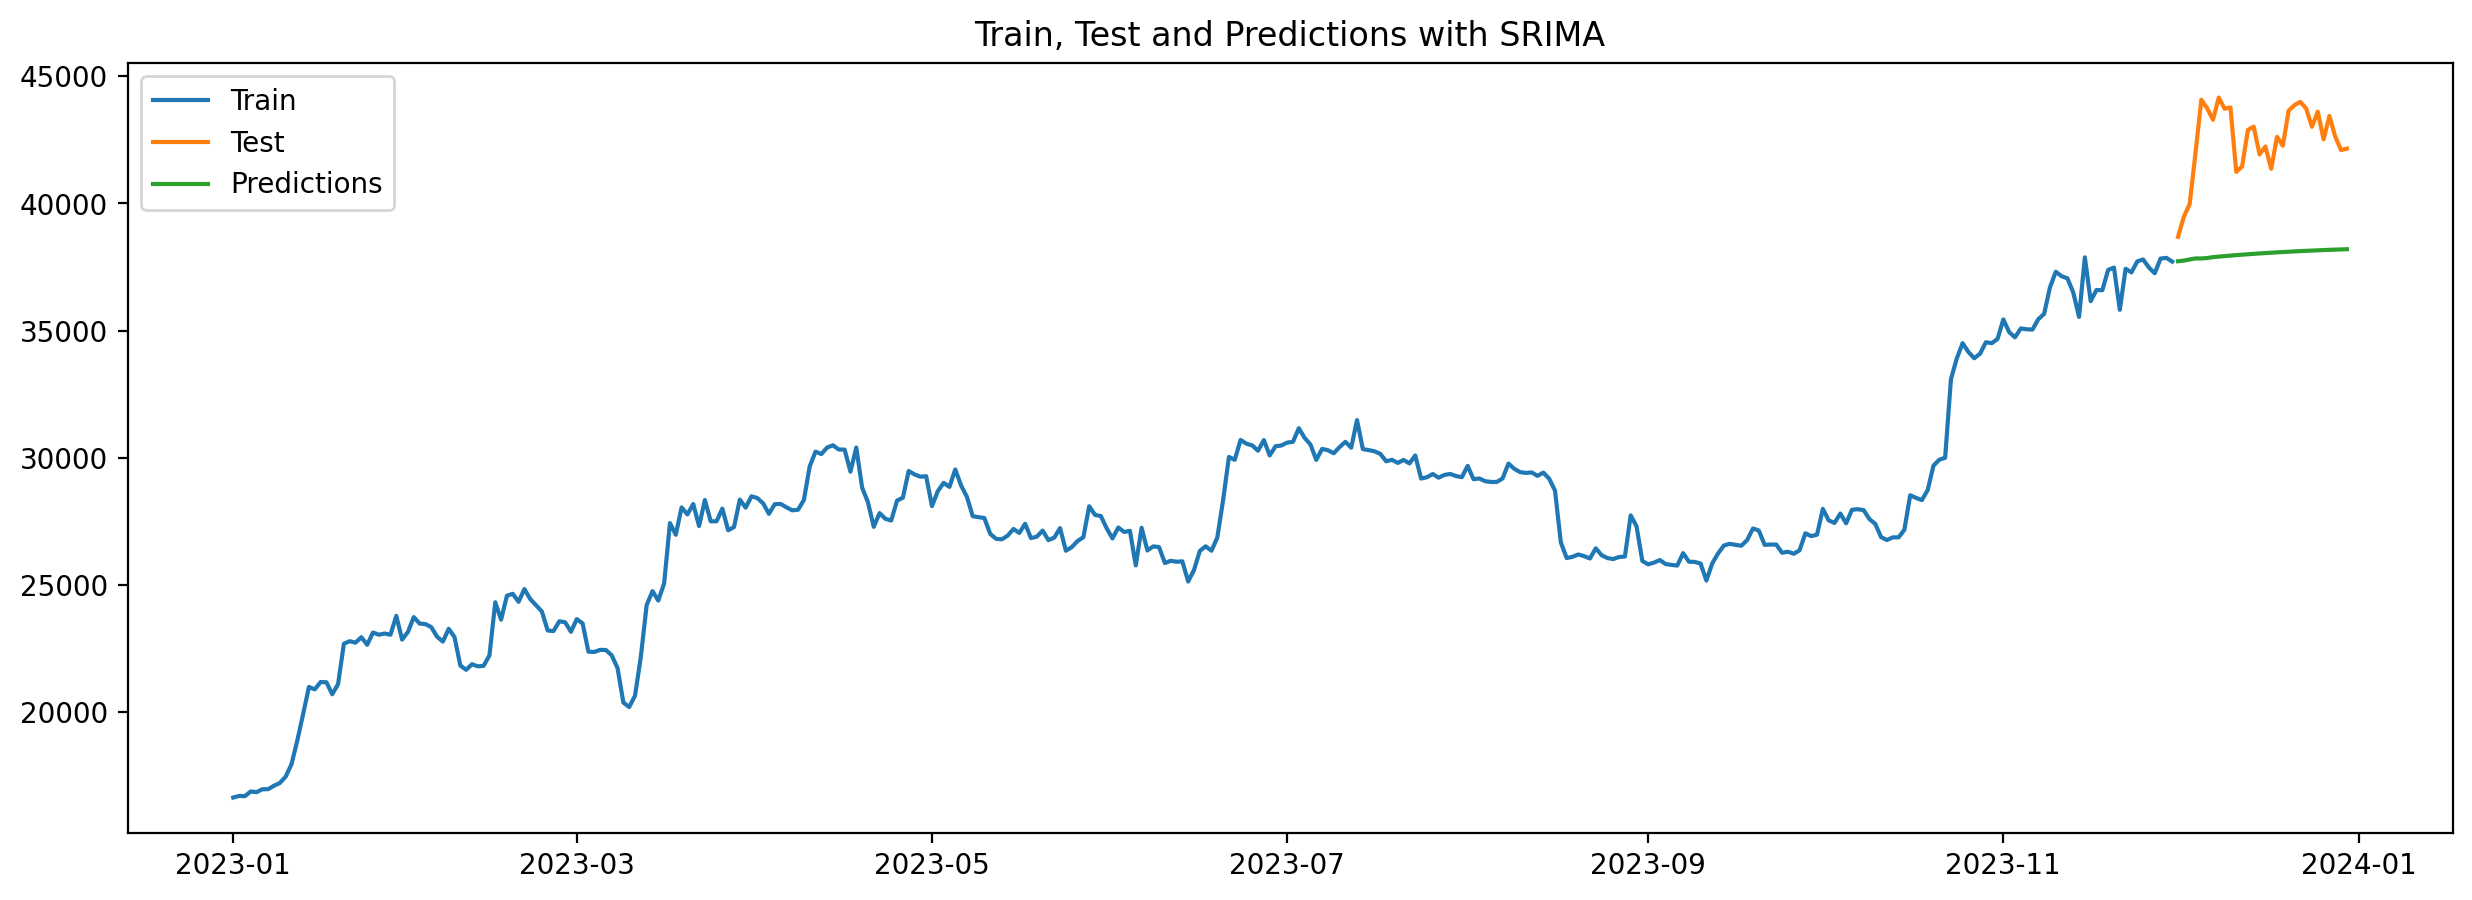

The MAE is 4541.52
The RMSE is 4725.29
The MAPE is 10.58%


In [115]:
model_assessment(train['y']['2023-01':], test['y'], predictions_srima, "SRIMA")

# SARIMAX

In [ ]:
# Training & Test Split of regressors
test_days = 30
columns_to_select = [0, 1, 2, 4]  # Specify the desired column indices
exog_train = df.iloc[:-test_days, columns_to_select]
exog_test = df.iloc[-test_days:, columns_to_select]
exog_test

In [ ]:
model_sarimax = auto_arima(train['y'], m=7, X=exog_train, stepwise=False) 
model_sarimax.summary()

In [58]:
# Predictions
predictions_sarimax = model_sarimax.predict(n_periods=len(test), X=exog_test)
predictions_sarimax

2023-12-01    38688.750000
2023-12-02    39476.332031
2023-12-03    39978.390625
2023-12-04    41980.097656
2023-12-05    44080.648437
2023-12-06    43746.445312
2023-12-07    43292.664062
2023-12-08    44166.601562
2023-12-09    43725.984375
2023-12-10    43779.699219
2023-12-11    41243.832031
2023-12-12    41450.222656
2023-12-13    42890.742187
2023-12-14    43023.972656
2023-12-15    41929.757812
2023-12-16    42240.117187
2023-12-17    41364.664062
2023-12-18    42623.539062
2023-12-19    42270.527344
2023-12-20    43652.250000
2023-12-21    43869.152344
2023-12-22    43997.902344
2023-12-23    43739.542969
2023-12-24    43016.117187
2023-12-25    43613.140625
2023-12-26    42520.402344
2023-12-27    43442.855469
2023-12-28    42627.855469
2023-12-29    42099.402344
2023-12-30    42156.902344
Freq: D, dtype: float64

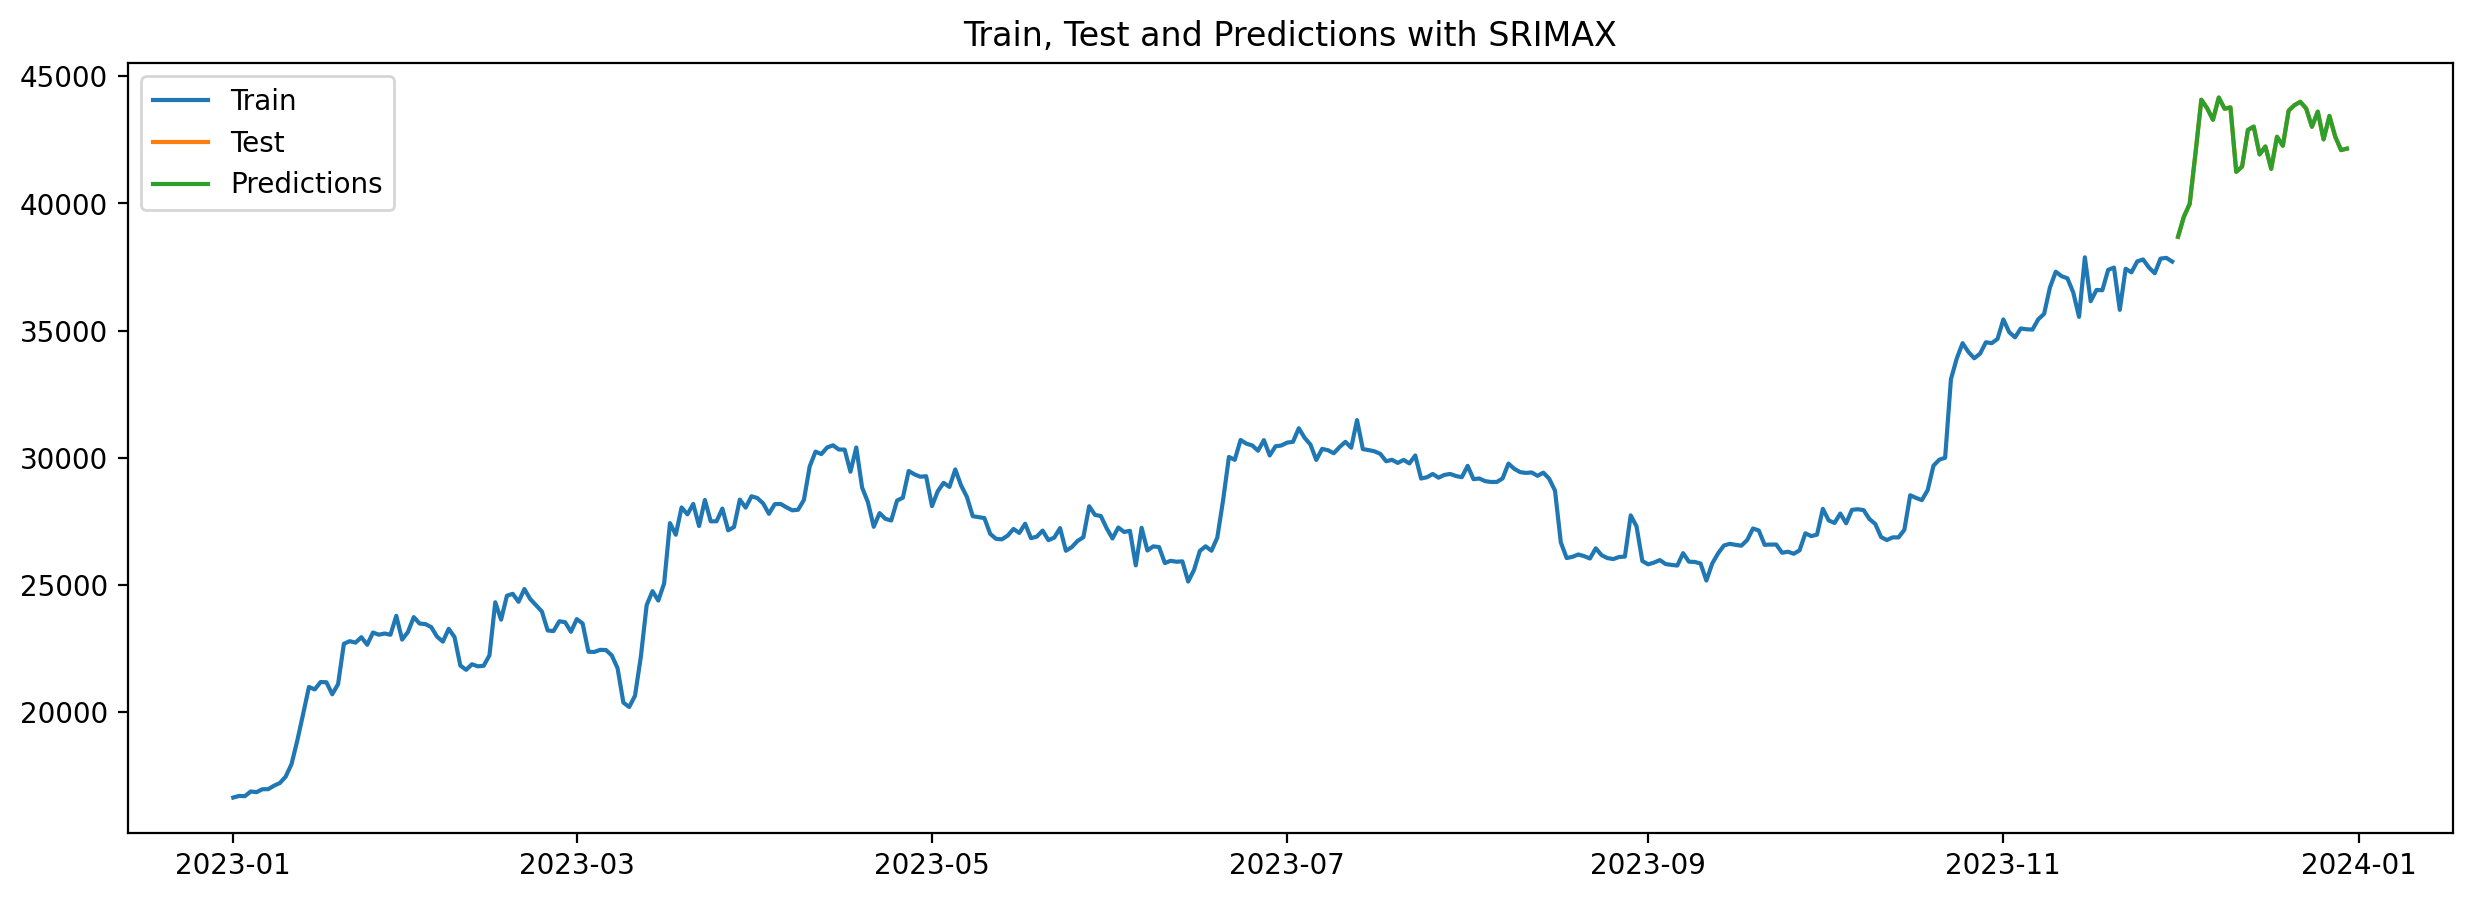

The MAE is 0.00
The RMSE is 0.00
The MAPE is 0.00%


In [60]:
model_assessment(train['y']['2023-01':], test['y'], predictions_sarimax ,"SRIMAX")